In [1]:
import numpy as np
from scipy.stats import unitary_group

import cirq
from cirq.ops import common_gates, raw_types
from cirq.sim import wave_function

In [2]:
import qutip

In [11]:
# Generate a random unitary

class RandomUnitaryGate(cirq.MatrixGate):
    
    def __init__(self, random_state = None, *, _random_gate = None):
        if _random_gate is None:
            mat = unitary_group.rvs(4, random_state = random_state)
        else:
            mat = _random_gate
        super().__init__(mat)
    
    def __pow__(self, n):
        if n == -1:
            mat = np.matrix(self._matrix).H
            return RandomUnitaryGate(_random_gate = np.array(mat))
    
    def __str__(self):
        return 'Rnd'
    
    def _circuit_diagram_info_(self, args):
        return 'Rnd', 'Rnd'
    

In [12]:
z = np.matrix([[1],[0]])
u = np.matrix([[0],[1]])
zz = np.kron(z,z)
zu = np.kron(z,u)
uz = np.kron(u,z)
uu = np.kron(u,u)

In [13]:
# Implements Gamma_2 from https://arxiv.org/pdf/1703.02999.pdf

class StateResetChannel(cirq.TwoQubitGate):
    
    def __init__(self, p1, p2):
        self.p1 = p1
        self.p2 = p2
        pass
    
    def _channel_(self):
        a1 = np.sqrt(self.p2)*np.dot(zz,zz.T) # sqrt(p2) |00><00|
        a2 = np.sqrt(self.p2)*np.dot(uu,uu.T) # sqrt(p2) |00><11|
        a3 = np.sqrt(1 - self.p2)*np.dot(uu, uu.T) # sqrt(1-p2) |11><11|
        a4 = np.sqrt(1 - self.p2)*np.dot(uu, zz.T) # sqrt(1-p2) |11><00|
        a5 = np.dot(uz, uz.T) # |01><01|
        a6 = np.dot(zu, zu.T) # |10><10|
        return (a1, a2, a3, a4, a5, a6)
    
    def __str__(self):
        return 'Γ'
    
    
    def _circuit_diagram_info_(self, args):
        return 'Γ', 'Γ({},{})'.format(self.p1, self.p2)
    

In [14]:
# A kind of ladder of gates

def ladder_shared_qubit(gates):
    for i, gate in enumerate(gates, start = 1):
        yield gate(cirq.LineQubit(0), cirq.LineQubit(i))

In [15]:
# Different ladder of gates

def ladder_shifting(gates):
    for i, gate in enumerate(gates):
        yield gate(cirq.LineQubit(i+1), cirq.LineQubit(i))

In [16]:
# Examples with Gamma_2
r = StateResetChannel(0.1, 0.1)
c1 = cirq.Circuit.from_ops(ladder_shared_qubit([r for i in range(5)]))
c2 = cirq.Circuit.from_ops(ladder_shifting([r for i in range(5)]))
print('First Ladder:')
print(c1)
print('\nSecond Ladder:')
print(c2)

First Ladder:
0: ───Γ────────────Γ────────────Γ────────────Γ────────────Γ────────────
      │            │            │            │            │
1: ───Γ(0.1,0.1)───┼────────────┼────────────┼────────────┼────────────
                   │            │            │            │
2: ────────────────Γ(0.1,0.1)───┼────────────┼────────────┼────────────
                                │            │            │
3: ─────────────────────────────Γ(0.1,0.1)───┼────────────┼────────────
                                             │            │
4: ──────────────────────────────────────────Γ(0.1,0.1)───┼────────────
                                                          │
5: ───────────────────────────────────────────────────────Γ(0.1,0.1)───

Second Ladder:
0: ───Γ(0.1,0.1)───────────────────────────────────────────────────────
      │
1: ───Γ────────────Γ(0.1,0.1)──────────────────────────────────────────
                   │
2: ────────────────Γ────────────Γ(0.1,0.1)───────────────────────

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Circuit.from_ops was used but is deprecated.
It will be removed in cirq v0.8.0.
use `cirq.Circuit(*ops)` instead.

  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Circuit.from_ops was used but is deprecated.
It will be removed in cirq v0.8.0.
use `cirq.Circuit(*ops)` instead.

  after removing the cwd from sys.path.


In [17]:
# Random circuit example. Each gate is chosen independently.
c_rnd= cirq.Circuit.from_ops(ladder_shared_qubit([RandomUnitaryGate() for i in range(5)]))
c_rnd

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Circuit.from_ops was used but is deprecated.
It will be removed in cirq v0.8.0.
use `cirq.Circuit(*ops)` instead.

  


0: ───Rnd───Rnd───Rnd───Rnd───Rnd───
      │     │     │     │     │
1: ───Rnd───┼─────┼─────┼─────┼─────
            │     │     │     │
2: ─────────Rnd───┼─────┼─────┼─────
                  │     │     │
3: ───────────────Rnd───┼─────┼─────
                        │     │
4: ─────────────────────Rnd───┼─────
                              │
5: ───────────────────────────Rnd───

In [18]:
cirq.inverse(c_rnd)

0: ───Rnd───Rnd───Rnd───Rnd───Rnd───
      │     │     │     │     │
1: ───┼─────┼─────┼─────┼─────Rnd───
      │     │     │     │
2: ───┼─────┼─────┼─────Rnd─────────
      │     │     │
3: ───┼─────┼─────Rnd───────────────
      │     │
4: ───┼─────Rnd─────────────────────
      │
5: ───Rnd───────────────────────────

In [19]:
# Generates unit complex vector

def random_vector(size):
    v = np.random.normal(size = size) + 1j * np.random.normal(size = size)
    v /= np.linalg.norm(v)
    return v.astype('complex64')

In [20]:
x = random_vector(2**6)

In [21]:
simulator = cirq.DensityMatrixSimulator()

In [22]:
q = cirq.NamedQubit('a')
circuit = cirq.Circuit.from_ops(cirq.H(q), cirq.amplitude_damp(0.2)(q))
simulator = cirq.DensityMatrixSimulator()
result = simulator.simulate(circuit)
print(result.final_density_matrix)


[[0.59999996+0.j 0.44721356+0.j]
 [0.44721356+0.j 0.39999998+0.j]]


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Circuit.from_ops was used but is deprecated.
It will be removed in cirq v0.8.0.
use `cirq.Circuit(*ops)` instead.

  


In [15]:
from cirqqulacs import QulacsSimulator


In [16]:
import cirq
from cirqqulacs import QulacsSimulator, QulacsDensityMatrixSimulator

qubit_n = 3
qubits = [cirq.LineQubit(i) for i in range(qubit_n)]
circuit = cirq.Circuit()
circuit.append(cirq.ops.X(qubits[0]))
circuit.append(cirq.ops.Rx(np.pi/5.5).on(qubits[1]))
circuit.append(cirq.ops.CCZ(qubits[0], qubits[1], qubits[2]))
result = QulacsDensityMatrixSimulator().simulate(circuit)


In [23]:
def trace0(den):
    """
    The result after tracing out everything but the first qubit, which is the last one in pyquil notation. 
    This is useful for finding the purity of the first qubit. 
    
    Args:
        den: The density matrix. A numpy matrix.
        
    Returns:
        The resulting matrix after tracing out.
    """
    m = den.shape[0]//2
    
    reshape_den = np.array(den).reshape([2,m,2,m])
    partial_trace = np.einsum('jiki->jk', reshape_den)
    return np.matrix(partial_trace)

## 9, 1000

In [24]:
test_n_qubits = 9
tot_tries = 1000

In [26]:
simulator = cirq.Simulator()

array([[ 1.0000000e+00+0.0000000e+00j, -2.9802321e-08-2.9802322e-08j],
       [-2.9802321e-08+2.9802322e-08j,  2.2069047e-14+0.0000000e+00j]],
      dtype=complex64)

In [36]:
# Running ten circuits of 5 qubits, with gates and initial state chosen randomly

n_qubits = test_n_qubits - 1

puritiesA = []

for i in range(tot_tries):
    c = cirq.Circuit.from_ops(ladder_shifting([RandomUnitaryGate() for i in range(n_qubits - 1)]))
    random_run = simulator.simulate(c + cirq.inverse(c))
    rho0 = random_run.density_matrix_of([cirq.LineQubit(0)])
    #cirq.partial_trace(random_run.final_simulator_state.density_matrix, [0]) 
    # Reduced density matrix of first qubit
    purity0 = np.trace(rho0*rho0)
    #print('overlap:',random_run.final_state[0]) # Should be <rho|0^n>
    #print('purity:',purity0)
    puritiesA.append(purity0)
    

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Circuit.from_ops was used but is deprecated.
It will be removed in cirq v0.8.0.
use `cirq.Circuit(*ops)` instead.

  


In [37]:
puritiesA

[(1+0j),
 (1+0j),
 (1+0j),
 (1+0j),
 (1+0j),
 (1+0j),
 (1+0j),
 (1+0j),
 (1.0000005+0j),
 (0.9999995+0j),
 (1.0000005+0j),
 (1+0j),
 (0.9999995+0j),
 (0.9999995+0j),
 (1.0000005+0j),
 (1.0000005+0j),
 (1+0j),
 (1+0j),
 (1+0j),
 (1+0j),
 (1+0j),
 (0.9999995+0j),
 (0.9999995+0j),
 (1.0000005+0j),
 (0.9999993+0j),
 (1+0j),
 (1+0j),
 (0.99999976+0j),
 (0.9999995+0j),
 (0.99999976+0j),
 (1+0j),
 (1+0j),
 (1+0j),
 (1+0j),
 (0.9999993+0j),
 (0.99999976+0j),
 (1+0j),
 (0.9999995+0j),
 (0.99999976+0j),
 (0.99999976+0j),
 (1+0j),
 (1+0j),
 (1+0j),
 (0.99999976+0j),
 (1.0000005+0j),
 (0.9999995+0j),
 (0.99999905+0j),
 (1.0000005+0j),
 (1.0000005+0j),
 (0.99999976+0j),
 (1+0j),
 (0.9999993+0j),
 (1+0j),
 (1.0000005+0j),
 (1+0j),
 (1+0j),
 (1.000001+0j),
 (0.9999988+0j),
 (1+0j),
 (1+0j),
 (1+0j),
 (1+0j),
 (0.9999993+0j),
 (0.9999995+0j),
 (1+0j),
 (0.9999995+0j),
 (1+0j),
 (1+0j),
 (1.0000005+0j),
 (1+0j),
 (0.99999976+0j),
 (1.0000005+0j),
 (0.9999995+0j),
 (1+0j),
 (1+0j),
 (1+0j),
 (1+0j),
 (1

In [608]:
# Running ten circuits of 5 qubits, with gates and initial state chosen randomly

n_qubits = test_n_qubits

puritiesB = []

for i in range(tot_tries):
    c = cirq.Circuit.from_ops(ladder_shifting([RandomUnitaryGate() for i in range(n_qubits - 1)]))
    random_run = simulator.simulate(c + cirq.inverse(c[:-1]))
    rho0 = cirq.partial_trace(random_run.final_simulator_state.density_matrix, [0]) 
    # Reduced density matrix of first qubit
    purity0 = np.trace(rho0*rho0)
    #print('overlap:',random_run.final_state[0]) # Should be <rho|0^n>
    #print('purity:',purity0)
    puritiesB.append(purity0)
    

In [609]:
puritiesB

[(0.88575256+9.176297e-09j),
 (0.828051-5.0153464e-08j),
 (0.6759024+2.8800404e-08j),
 (0.9037277-2.560015e-08j),
 (0.8548829+2.5420743e-08j),
 (0.93753326-4.21957e-08j),
 (0.8157846+3.8078106e-08j),
 (0.90947986+3.490953e-09j),
 (0.85112363+1.738865e-09j),
 (0.8471898-1.6238396e-08j),
 (0.85544956-1.2130179e-09j),
 (0.9018509-1.1948458e-08j),
 (0.7787226-3.0892857e-09j),
 (0.8945378-4.0025448e-08j),
 (0.73576+4.3207418e-08j),
 (0.66009873+2.7793632e-08j),
 (0.87999743+3.3658473e-08j),
 (0.93355024-1.3794233e-08j),
 (0.70614743-2.4300196e-08j),
 (0.7344123-1.4506161e-08j),
 (0.81873-1.490698e-08j),
 (0.79753226-4.2305764e-08j),
 (0.7946272-7.814186e-09j),
 (0.68897456-9.779028e-09j),
 (0.9434477-2.036461e-08j),
 (0.6280161-1.4139074e-08j),
 (0.8988614+1.0171648e-08j),
 (0.7775491-2.2333081e-08j),
 (0.79830307+5.1779708e-08j),
 (0.87167364-2.1282613e-08j),
 (0.87777025-1.21930395e-08j),
 (0.93753564-9.983787e-08j),
 (0.7025071-1.38637875e-08j),
 (0.72196376+5.181116e-08j),
 (0.73528963-

In [610]:

# Running ten circuits of 5 qubits, with gates and initial state chosen randomly

n_qubits = test_n_qubits

puritiesC = []

for i in range(tot_tries):
    v = np.matrix(random_vector(2**n_qubits))
    rho0 = trace0(v.H*v)
    # Reduced density matrix of first qubit
    purity0 = np.trace(rho0*rho0)
    #print('overlap:',random_run.final_state[0]) # Should be <rho|0^n>
    #print('purity:',purity0)
    puritiesC.append(purity0)
    

In [611]:
pA = np.array(list(map(abs, puritiesA)))
pB = np.array(list(map(abs, puritiesB)))
pC = np.array(list(map(abs, puritiesC)))

In [612]:
import matplotlib.pyplot as plt

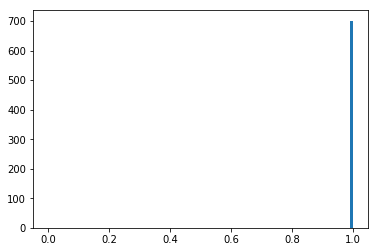

In [613]:
plt.hist(pA, range=(0,1), bins=100)
plt.show()

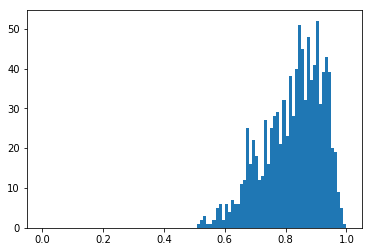

In [614]:
plt.hist(pB, range=(0,1), bins=100)
plt.show()

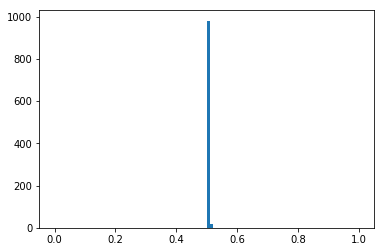

In [615]:
plt.hist(pC, range=(0,1), bins=100)
plt.show()

## 10, 100

In [616]:
test_n_qubits = 10
tot_tries = 100

In [617]:
# Running ten circuits of 5 qubits, with gates and initial state chosen randomly

n_qubits = test_n_qubits - 1

puritiesA = []

for i in range(tot_tries):
    c = cirq.Circuit.from_ops(ladder_shifting([RandomUnitaryGate() for i in range(n_qubits - 1)]))
    random_run = simulator.simulate(c + cirq.inverse(c))
    rho0 = cirq.partial_trace(random_run.final_simulator_state.density_matrix, [0]) 
    # Reduced density matrix of first qubit
    purity0 = np.trace(rho0*rho0)
    #print('overlap:',random_run.final_state[0]) # Should be <rho|0^n>
    #print('purity:',purity0)
    puritiesA.append(purity0)
    

In [619]:
# Running ten circuits of 5 qubits, with gates and initial state chosen randomly

n_qubits = test_n_qubits

puritiesB = []

for i in range(tot_tries):
    c = cirq.Circuit.from_ops(ladder_shifting([RandomUnitaryGate() for i in range(n_qubits - 1)]))
    random_run = simulator.simulate(c + cirq.inverse(c[:-1]))
    rho0 = cirq.partial_trace(random_run.final_simulator_state.density_matrix, [0]) 
    # Reduced density matrix of first qubit
    purity0 = np.trace(rho0*rho0)
    #print('overlap:',random_run.final_state[0]) # Should be <rho|0^n>
    #print('purity:',purity0)
    puritiesB.append(purity0)
    

In [621]:

# Running ten circuits of 5 qubits, with gates and initial state chosen randomly

n_qubits = test_n_qubits

puritiesC = []

for i in range(tot_tries):
    v = np.matrix(random_vector(2**n_qubits))
    rho0 = trace0(v.H*v)
    # Reduced density matrix of first qubit
    purity0 = np.trace(rho0*rho0)
    #print('overlap:',random_run.final_state[0]) # Should be <rho|0^n>
    #print('purity:',purity0)
    puritiesC.append(purity0)
    

In [622]:
pA = np.array(list(map(abs, puritiesA)))
pB = np.array(list(map(abs, puritiesB)))
pC = np.array(list(map(abs, puritiesC)))

In [35]:
import matplotlib.pyplot as plt

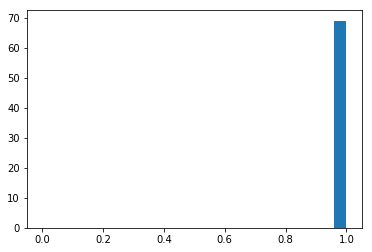

In [627]:
plt.hist(pA, range=(0,1), bins=25)
plt.show()

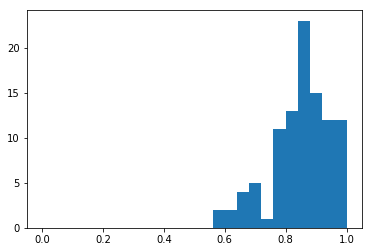

In [628]:
plt.hist(pB, range=(0,1), bins=25)
plt.show()

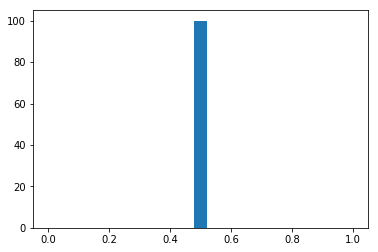

In [629]:
plt.hist(pC, range=(0,1), bins=25)
plt.show()

## 8, 100

In [36]:
test_n_qubits = 6
tot_tries = 1000

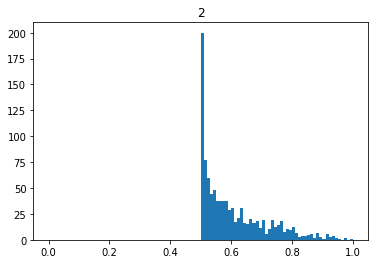

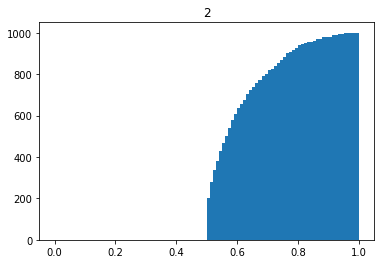

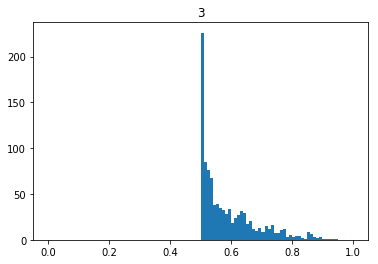

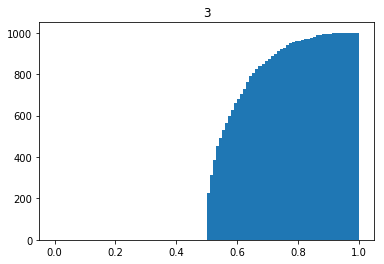

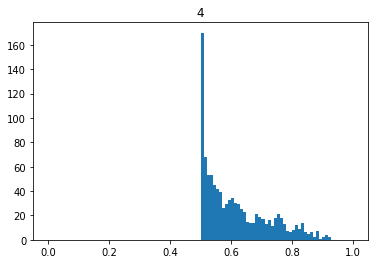

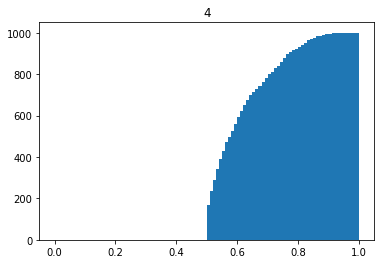

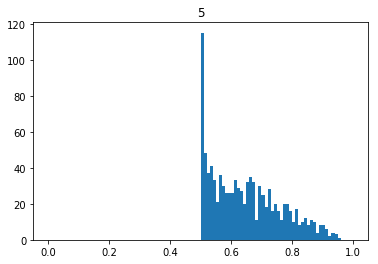

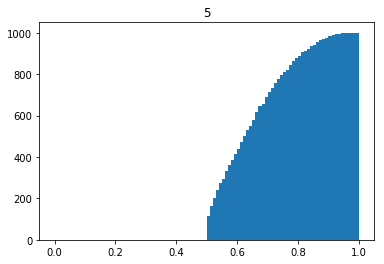

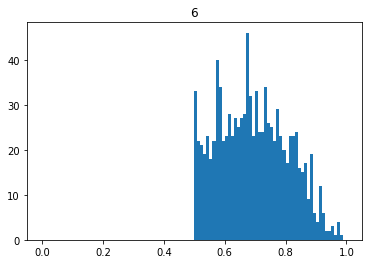

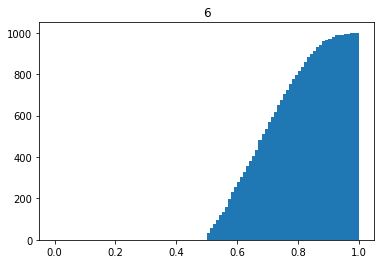

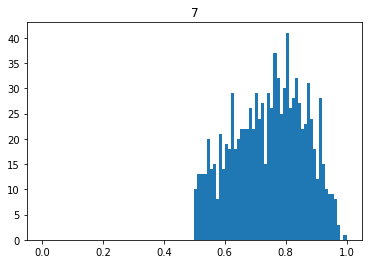

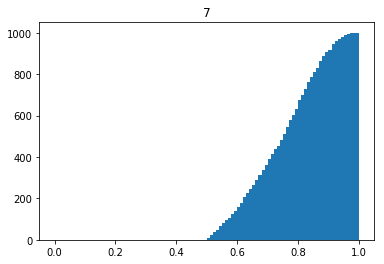

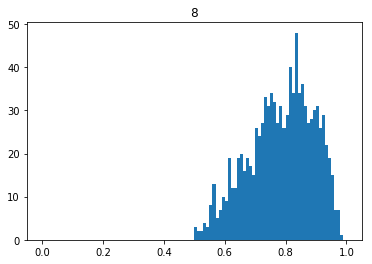

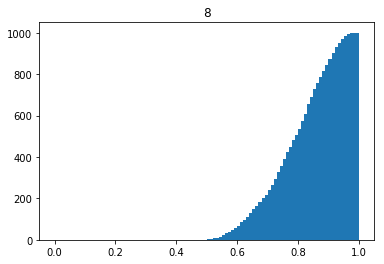

In [686]:
# Running ten circuits of 5 qubits, with gates and initial state chosen randomly
for test_n_qubits in [2,3,4,5,6,7,8]:
    n_qubits = test_n_qubits
    
    puritiesB = []

    for i in range(tot_tries):
        c = cirq.Circuit.from_ops(ladder_shifting([RandomUnitaryGate() for i in range(n_qubits - 1)]))
        random_run = simulator.simulate(c + cirq.inverse(c[:-1]))
        rho0 = cirq.partial_trace(random_run.final_simulator_state.density_matrix, [0]) 
        # Reduced density matrix of first qubit
        purity0 = np.trace(rho0*rho0)
        #print('overlap:',random_run.final_state[0]) # Should be <rho|0^n>
        #print('purity:',purity0)
        puritiesB.append(purity0)

    pB = np.array(list(map(abs, puritiesB)))

    plt.hist(pB, range=(0,1), bins=100)
    plt.title(str(test_n_qubits))
    plt.show()
    
    plt.hist(pB, range=(0,1), bins=100, cumulative=1)
    plt.title(str(test_n_qubits))
    plt.show()
    

In [38]:
import os

import pathlib

In [39]:
import imageio

In [40]:
import matplotlib.pyplot as plt

In [41]:
isaac_folder = pathlib.Path.cwd()
isaac_images = isaac_folder.joinpath('dmera_images')
isaac_images.mkdir(parents = True, exist_ok = True)

In [44]:
def make_gif(n_qubits, unformated_name):
    images = []
    for i in range(0, n_qubits - 1):
        image_name = unformated_name.format(n_qubits = n_qubits, i = i) + '.png'

        images.append(imageio.imread(isaac_images.joinpath(image_name)))

    for i in range(n_qubits - 2, -1, -1):
        image_name = unformated_name.format(n_qubits = n_qubits, i = i) + '.png'

        images.append(imageio.imread(isaac_images.joinpath(image_name)))

    gif_name = unformated_name.format(n_qubits = n_qubits, i = 'total') + '_compiled.gif'
    imageio.mimsave(isaac_images.joinpath(gif_name), images)

In [42]:
def fidelity_against_0(rho):
    return qutip.metrics.fidelity(qutip.Qobj(rho),qutip.basis(2,0))

In [43]:
import matplotlib.pyplot as plt

In [51]:
from tqdm.notebook import tqdm

In [27]:
from cirqqulacs import QulacsSimulator, QulacsDensityMatrixSimulator

In [41]:
simulator = QulacsDensityMatrixSimulator()
simulator = QulacsSimulator()

In [75]:
qutip.Qobj?

In [46]:
make_gif(17, 'cummulative_fidelity_circuit_size_{n_qubits}_qubit_number_{i}')

In [76]:
qutip.Qobj(
    random_run.density_matrix_of([cirq.LineQubit(0), cirq.LineQubit(1)]))

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.68101817+0.j          0.02141253+0.02538262j -0.00133079-0.02704907j
   0.01840031-0.0575226j ]
 [ 0.02141253-0.02538262j  0.13447216+0.j         -0.02042672+0.02721864j
  -0.07436338-0.08579882j]
 [-0.00133079+0.02704907j -0.02042672-0.02721864j  0.02995278+0.j
  -0.01289721+0.03090658j]
 [ 0.01840031+0.0575226j  -0.07436338+0.08579882j -0.01289721-0.03090658j
   0.15455639+0.j        ]]

In [102]:
qo = qutip.Qobj(
    x
    ,
    dims = [[2,2],[2,2]]
)
qo

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.68101817+0.j          0.02141253+0.02538262j -0.00133079-0.02704907j
   0.01840031-0.0575226j ]
 [ 0.02141253-0.02538262j  0.13447216+0.j         -0.02042672+0.02721864j
  -0.07436338-0.08579882j]
 [-0.00133079+0.02704907j -0.02042672-0.02721864j  0.02995278+0.j
  -0.01289721+0.03090658j]
 [ 0.01840031+0.0575226j  -0.07436338+0.08579882j -0.01289721-0.03090658j
   0.15455639+0.j        ]]

In [103]:
qutip.concurrence(qo)

0.03230446441716677





10


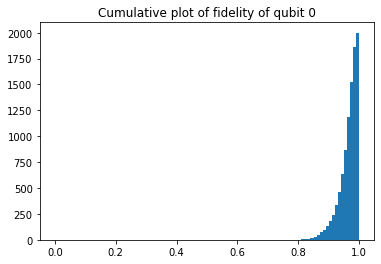

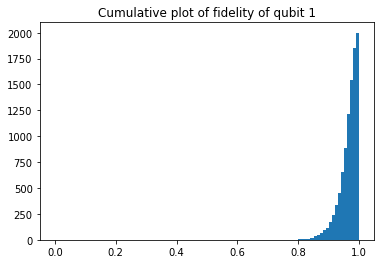

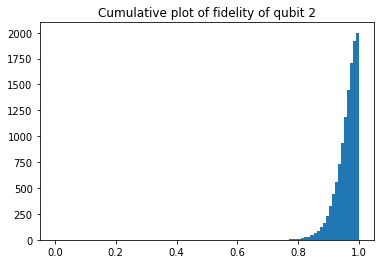

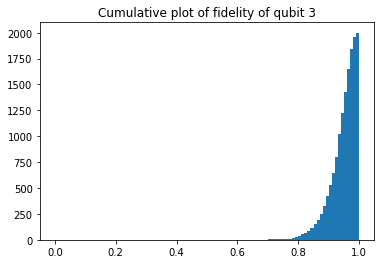

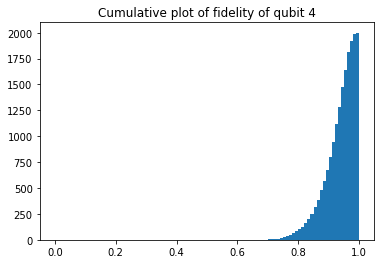

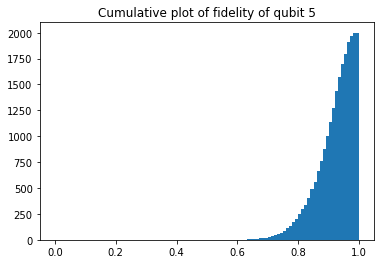

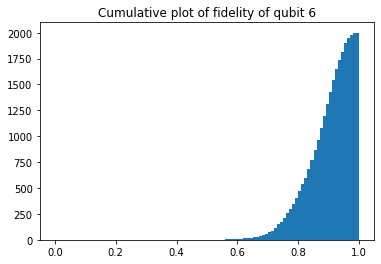

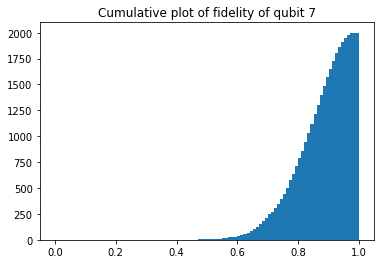

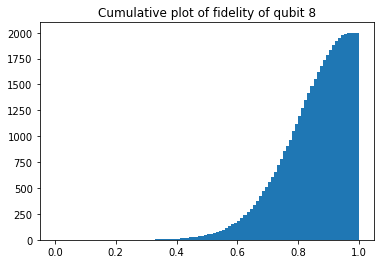

In [128]:
# Running ten circuits of 5 qubits, with gates and initial state chosen randomly
tot_tries = 2000
for test_n_qubits in [10]:
    print('\n\n\n')
    n_qubits = test_n_qubits
    print(n_qubits)

    fidelities = []
    
    for i in range(n_qubits - 1):
        fidelities.append([])
        
    concurr = []
    for i in range(n_qubits - 1):
        concurr.append([])
        for j in range(n_qubits - 1):
            concurr[i].append([])

    for i in tqdm(range(tot_tries)):
        c = cirq.Circuit(ladder_shifting([RandomUnitaryGate() for i in range(n_qubits - 1)]))
        random_run = simulator.simulate(c + cirq.inverse(c[:-1]))
        
        for i in range(n_qubits - 1):
            rho0 = random_run.density_matrix_of([cirq.LineQubit(i)])
            
            fidelities[i].append(fidelity_against_0(rho0))
            
        for i in range(n_qubits - 1):
            for j in range(n_qubits - 1):
                if i == j:
                    continue
                rho = random_run.density_matrix_of([cirq.LineQubit(i), cirq.LineQubit(j)])
                qo = qutip.Qobj(rho, dims = [[2,2],[2,2]])
                concurr[i][j].append(qutip.concurrence(qo))
        
    for i in range(n_qubits - 1):
        fidelities[i] = np.array(fidelities[i])

    # plot fidelities 
        
    for i in range(n_qubits - 1):
        
        fig = plt.figure()
        
        ax = fig.add_subplot(1,1,1)
        ax.hist(fidelities[i], range=(0,1), bins=100, cumulative=1)
        ax.set_title('Cumulative plot of fidelity of qubit ' + str(i))
        
        image_name = f'cummulative_fidelity_circuit_size_{n_qubits}_qubit_number_{i}.png'
        
        #plt.savefig(isaac_images / image_name)
        
        plt.show()
        
    #make_gif(n_qubits, metric = 'fidelity')



(array([760., 284., 231., 186., 140., 111.,  79.,  56.,  43.,  28.,  25.,
         21.,   9.,   7.,   7.,   5.,   4.,   2.,   1.,   1.]),
 array([0.        , 0.01556583, 0.03113167, 0.0466975 , 0.06226333,
        0.07782917, 0.093395  , 0.10896084, 0.12452667, 0.1400925 ,
        0.15565834, 0.17122417, 0.18679   , 0.20235584, 0.21792167,
        0.23348751, 0.24905334, 0.26461917, 0.28018501, 0.29575084,
        0.31131667]),
 <a list of 20 Patch objects>)

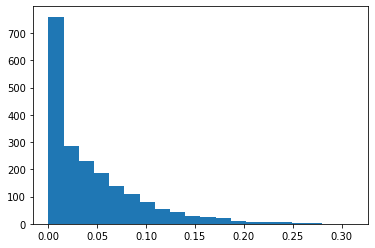

In [129]:
plt.hist(concurr[0][1], bins=20)

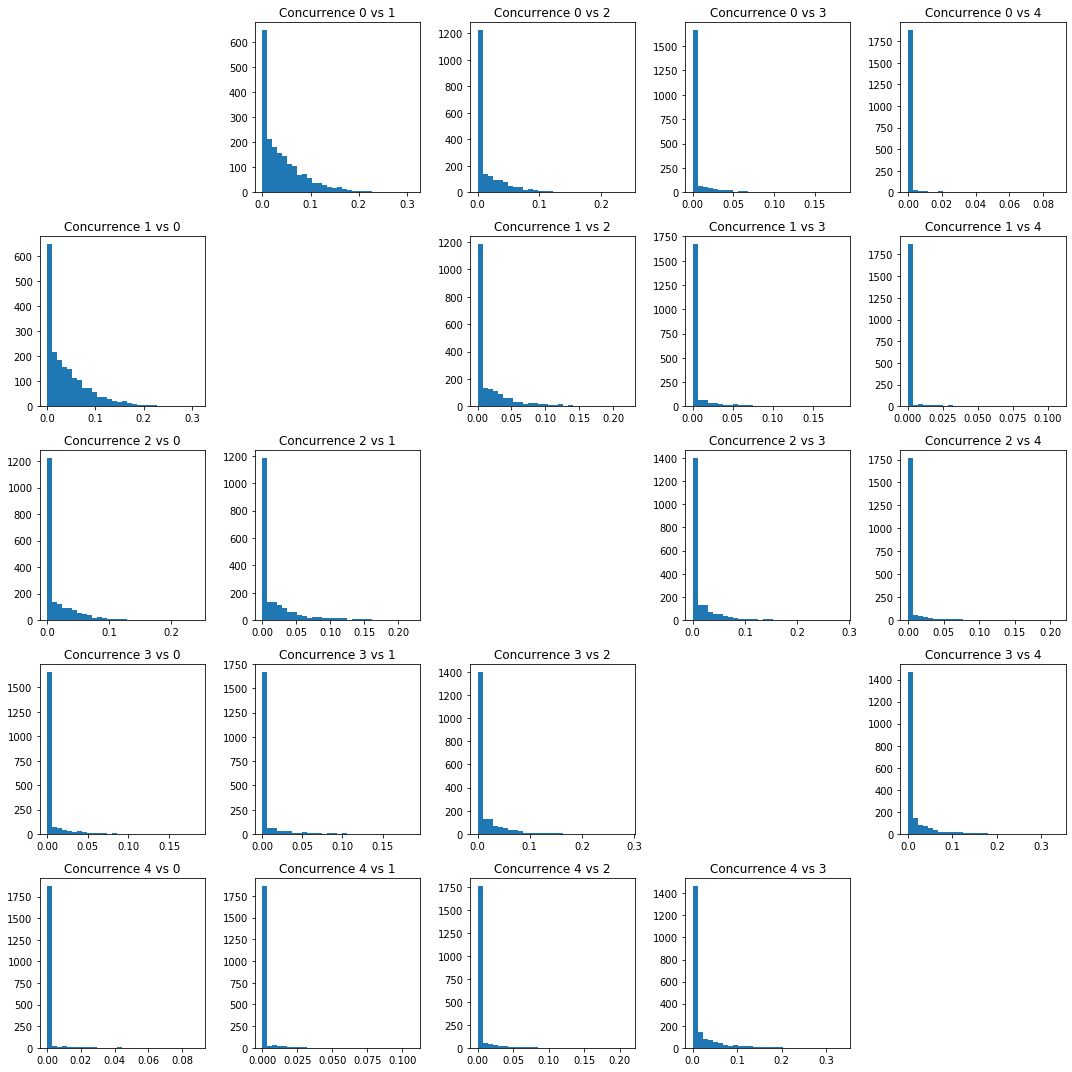

In [130]:
fig=plt.figure(figsize=(15, 15))
t = 0
for i in range(5):
    
    for j in range(5):
        t+=1
        if i == j:
            continue
        ax=fig.add_subplot(5,5, t)
        
        ax.hist(concurr[i][j], bins = 30)
        ax.set_title(f"Concurrence {i} vs {j}")
fig.tight_layout()  # Improves appearance a bit.
plt.savefig('concurrences_small.png')
plt.show()


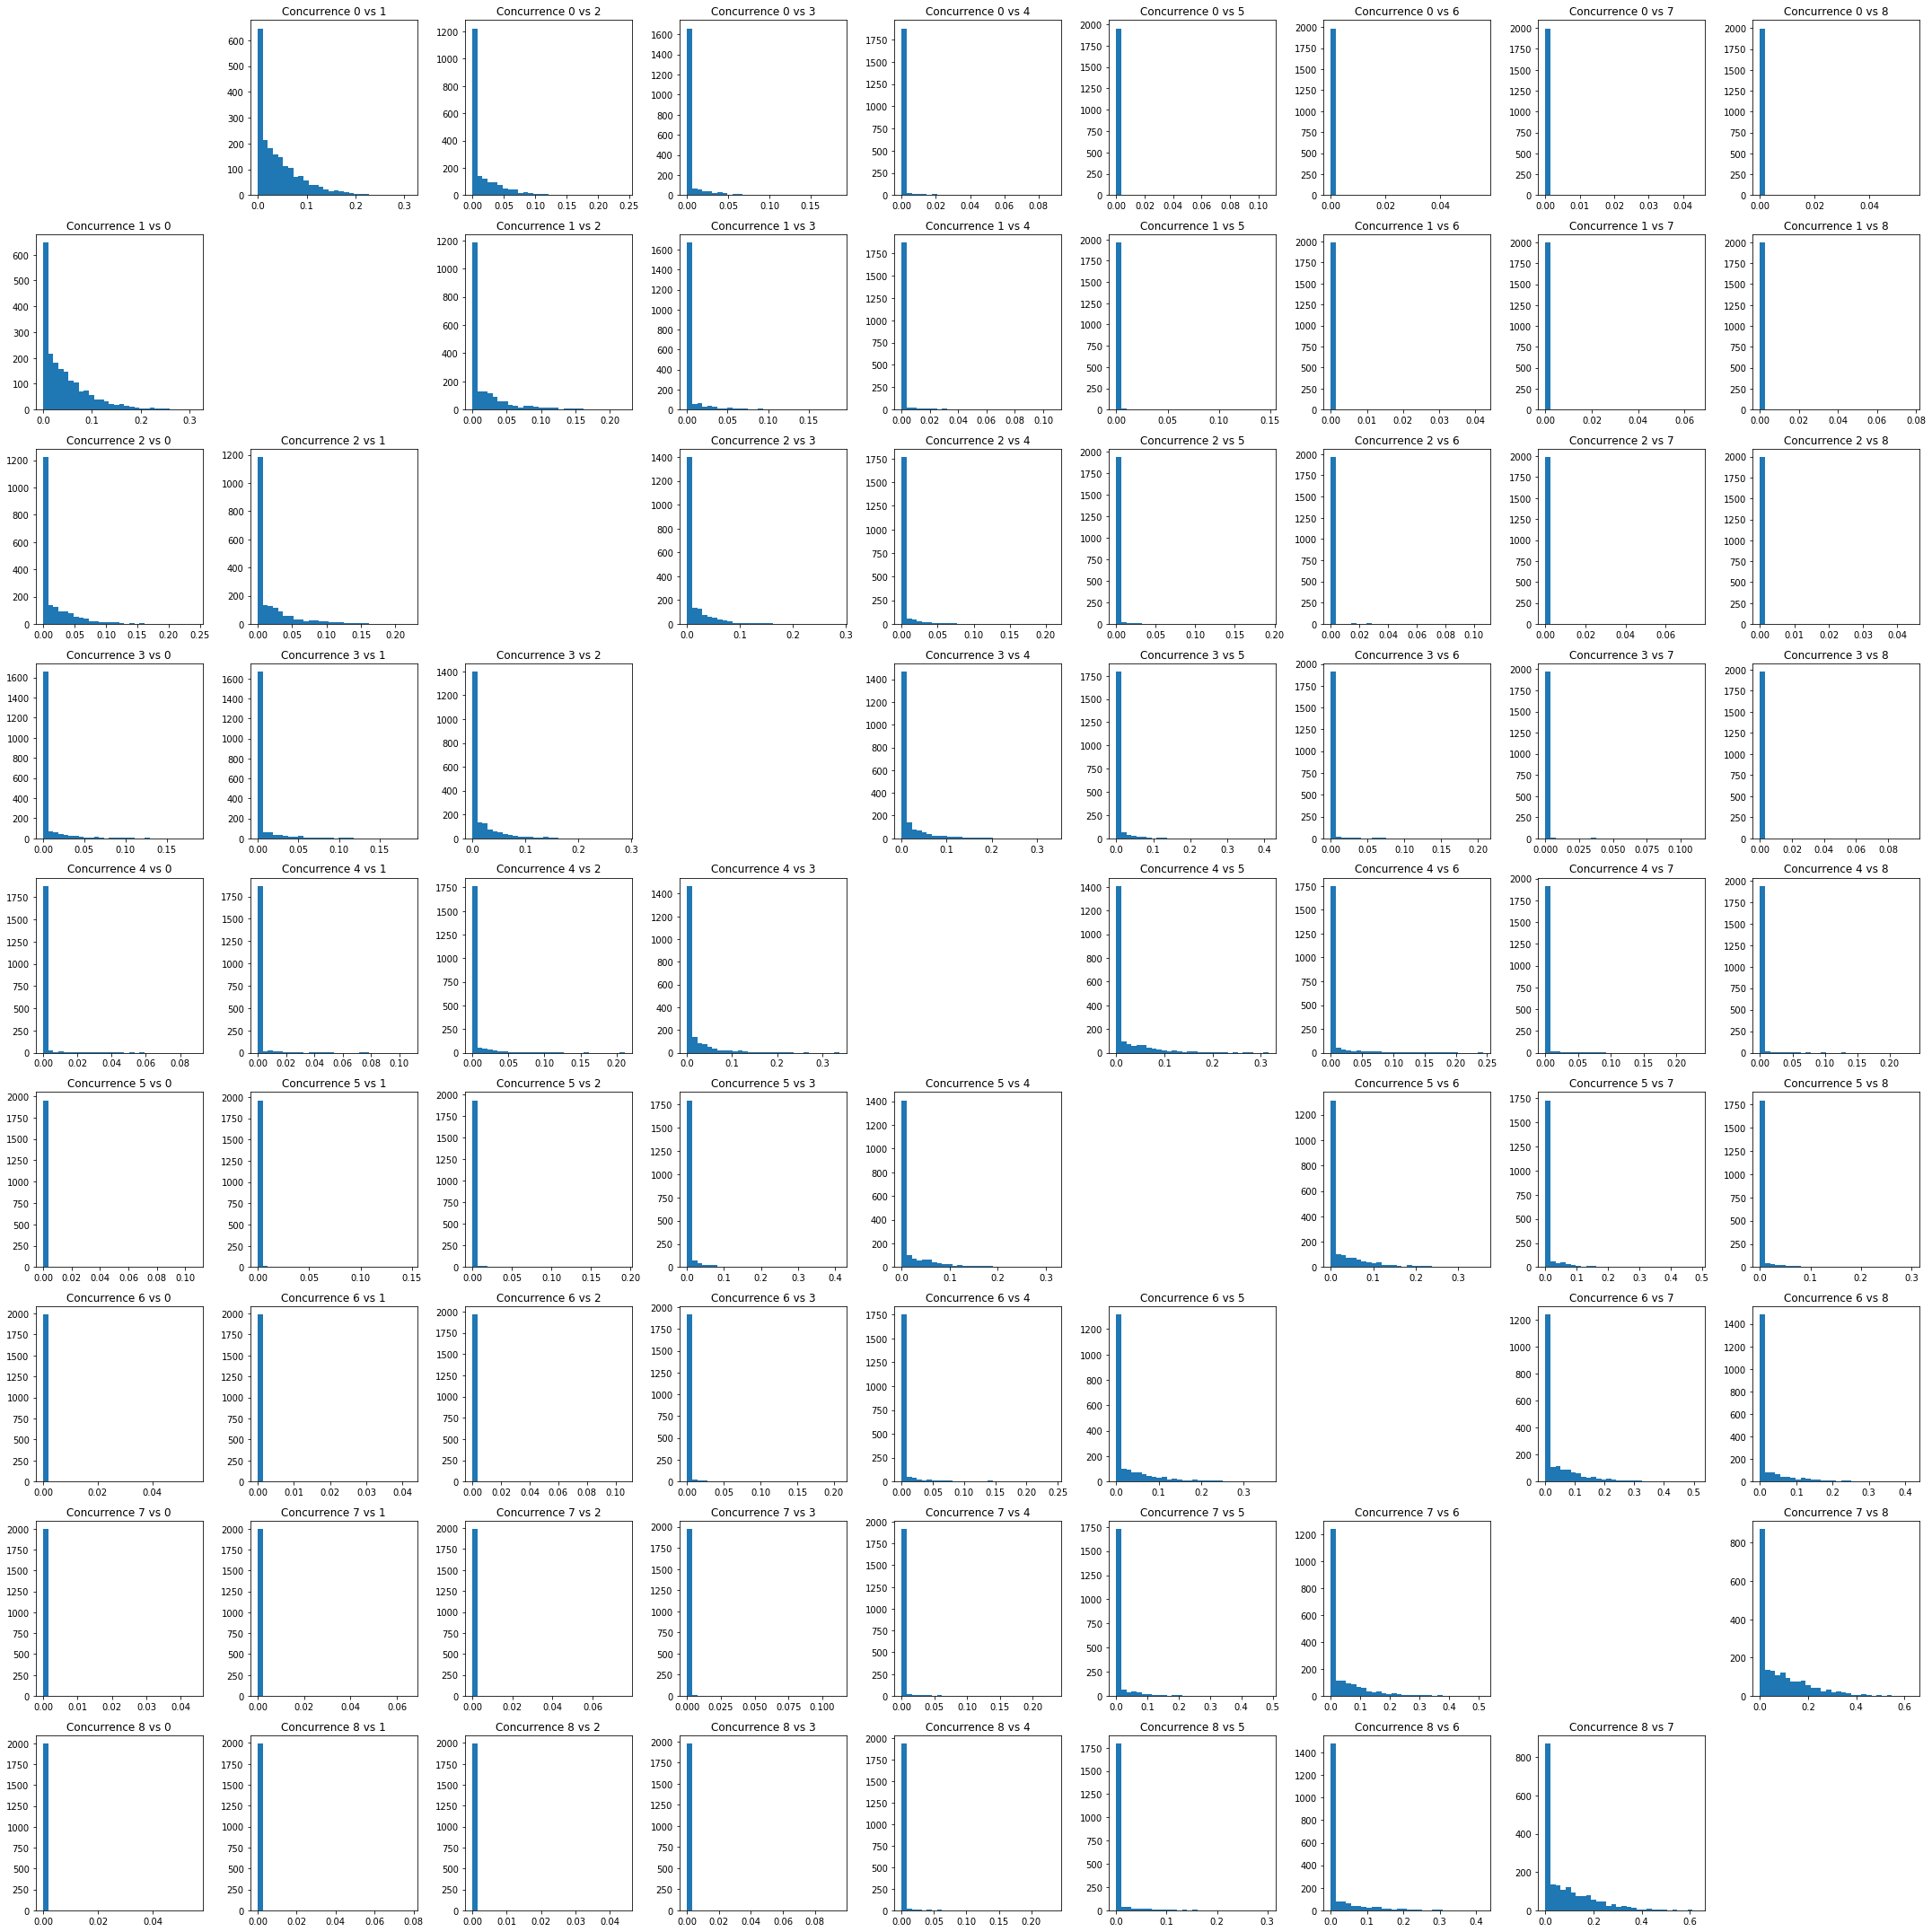

In [131]:
fig=plt.figure(figsize=(30, 30))
t = 0
for i in range(9):
    
    for j in range(9):
        t+=1
        if i == j:
            continue
        ax=fig.add_subplot(9,9, t)
        
        ax.hist(concurr[i][j], bins = 30)
        ax.set_title(f"Concurrence {i} vs {j}")
fig.tight_layout()  # Improves appearance a bit.
plt.savefig('concurrences_bigger.png')
plt.show()






10


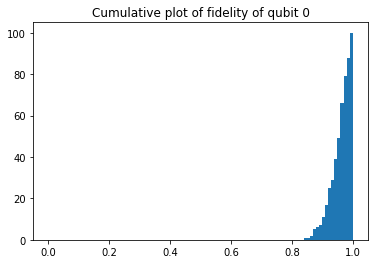

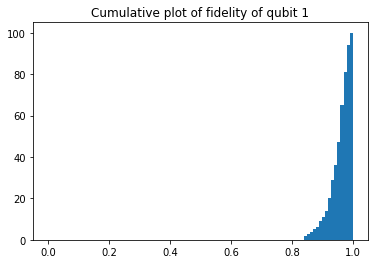

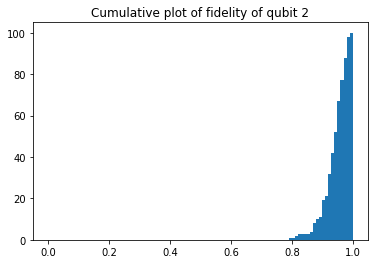

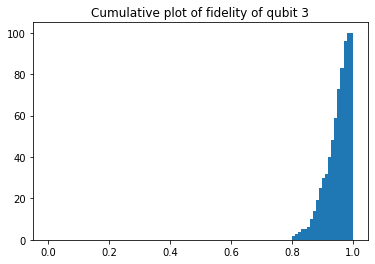

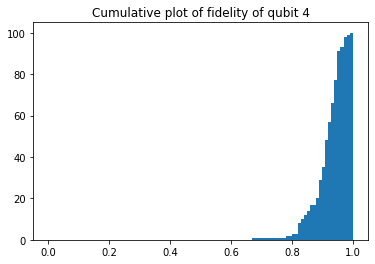

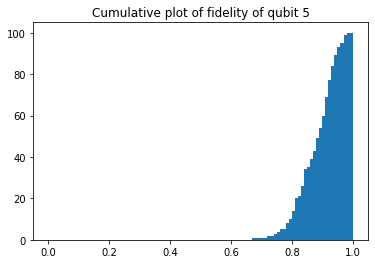

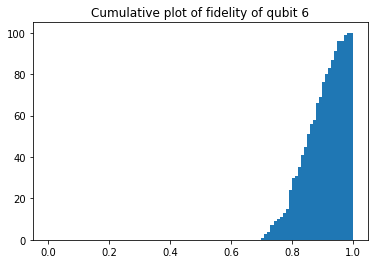

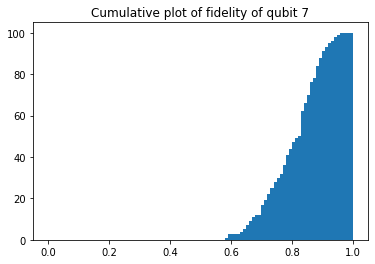

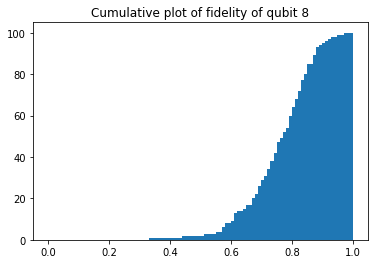

In [56]:
# Running ten circuits of 5 qubits, with gates and initial state chosen randomly
tot_tries = 100
for test_n_qubits in [10]:
    print('\n\n\n')
    n_qubits = test_n_qubits
    print(n_qubits)

    fidelities = []
    
    for i in range(n_qubits - 1):
        fidelities.append([])

    for i in tqdm(range(tot_tries)):
        c = cirq.Circuit(ladder_shifting([RandomUnitaryGate() for i in range(n_qubits - 1)]))
        random_run = simulator.simulate(c + cirq.inverse(c[:-1]))
        
        for i in range(n_qubits - 1):
            rho0 = random_run.density_matrix_of([cirq.LineQubit(i)])
            
            fidelities[i].append(fidelity_against_0(rho0))
        
    for i in range(n_qubits - 1):
        fidelities[i] = np.array(fidelities[i])

    # plot fidelities 
        
    for i in range(n_qubits - 1):
        
        fig = plt.figure()
        
        ax = fig.add_subplot(1,1,1)
        ax.hist(fidelities[i], range=(0,1), bins=100, cumulative=1)
        ax.set_title('Cumulative plot of fidelity of qubit ' + str(i))
        
        image_name = f'cummulative_fidelity_circuit_size_{n_qubits}_qubit_number_{i}.png'
        
        #plt.savefig(isaac_images / image_name)
        
        plt.show()
        
    #make_gif(n_qubits, metric = 'fidelity')







2


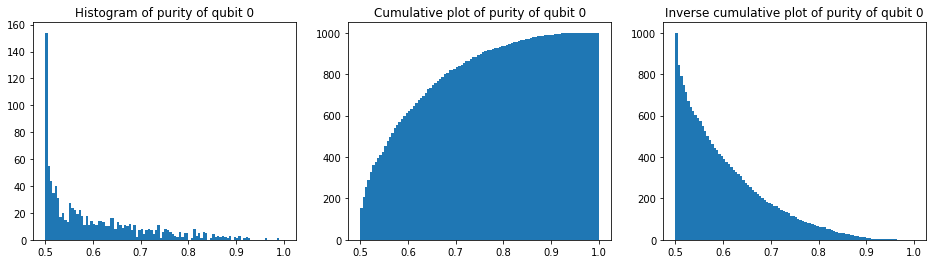

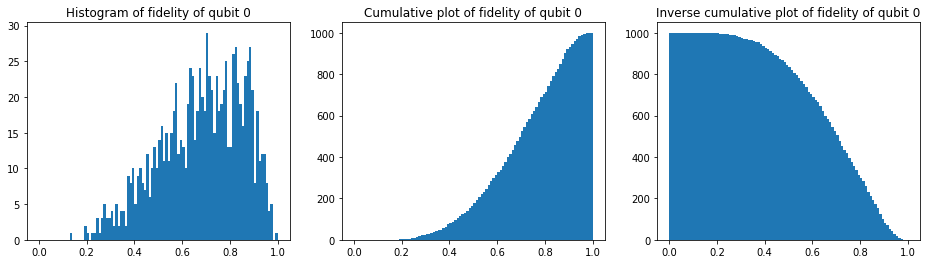





3


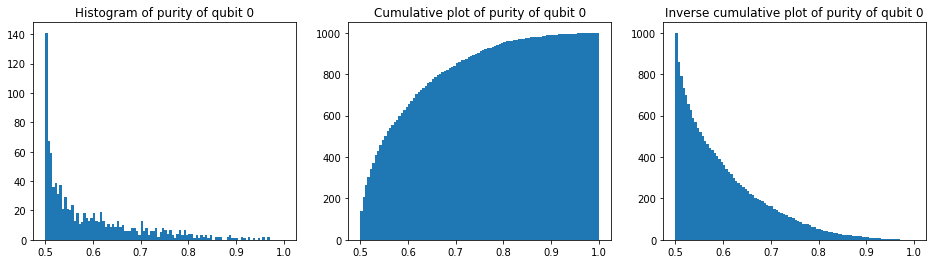

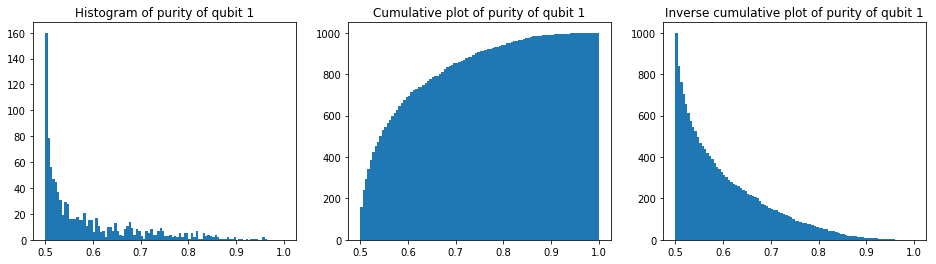

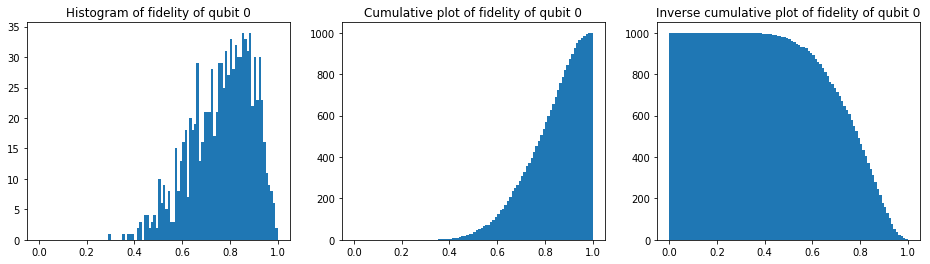

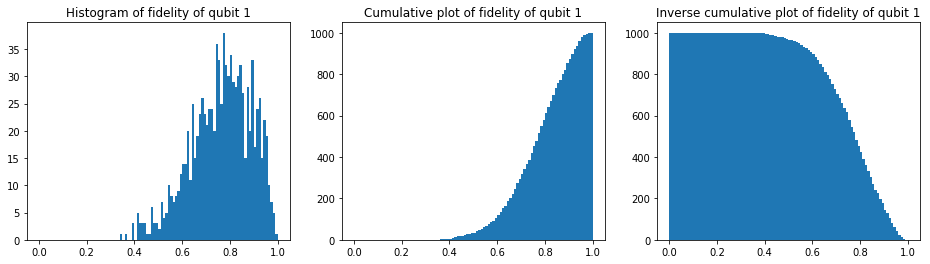





4


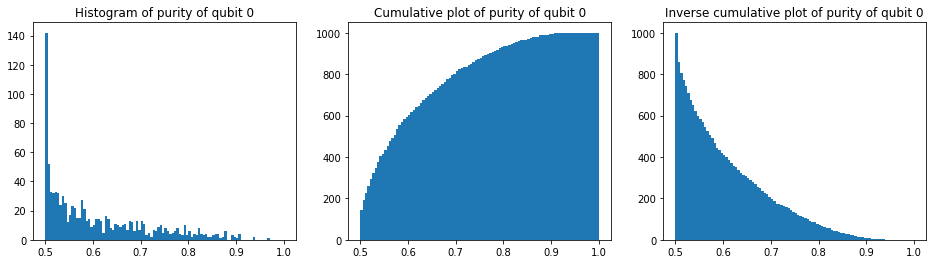

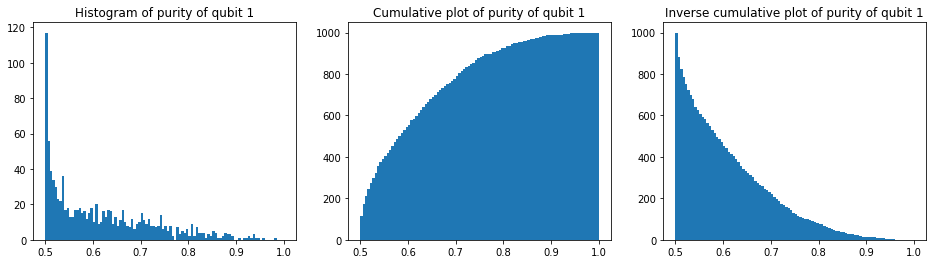

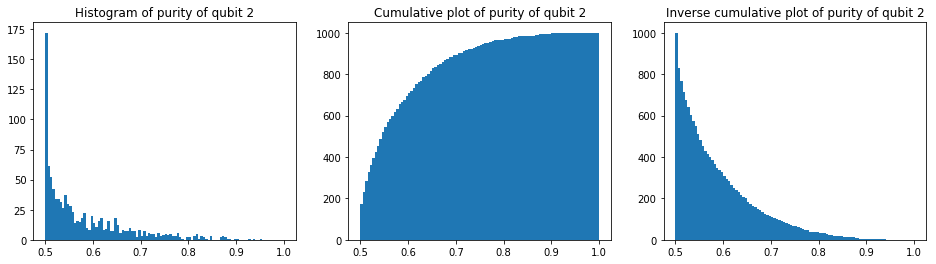

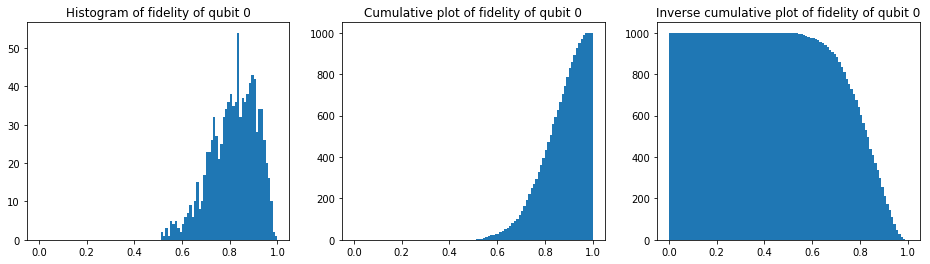

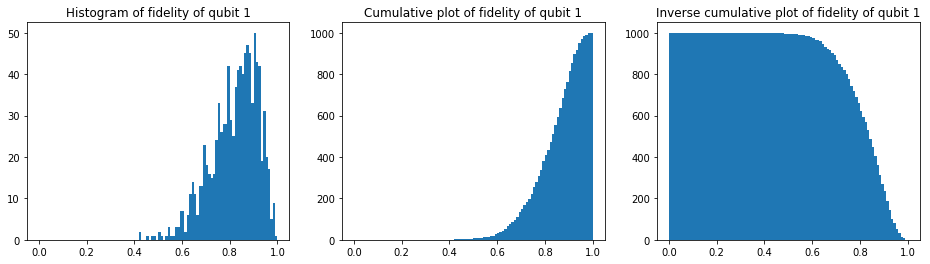

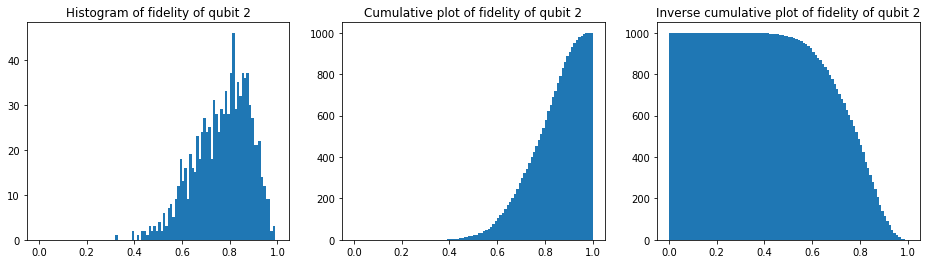





5


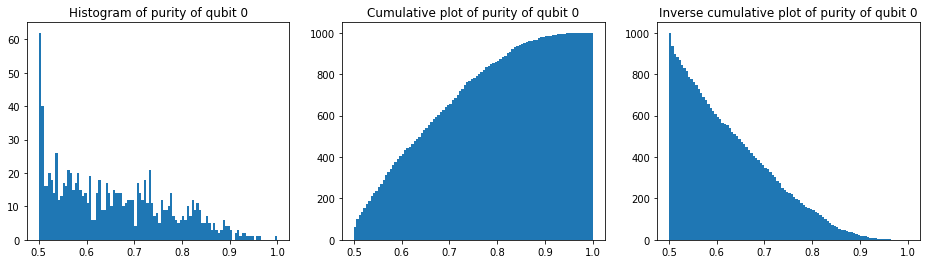

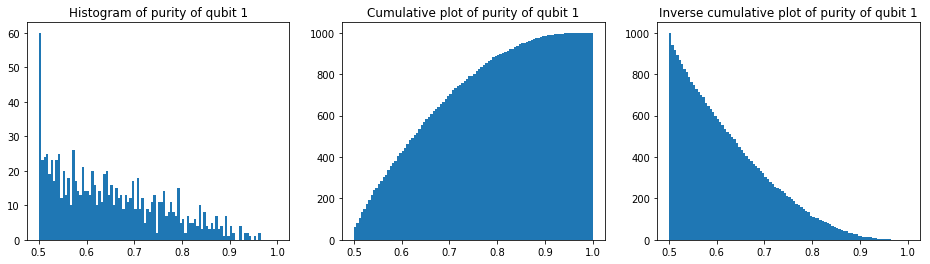

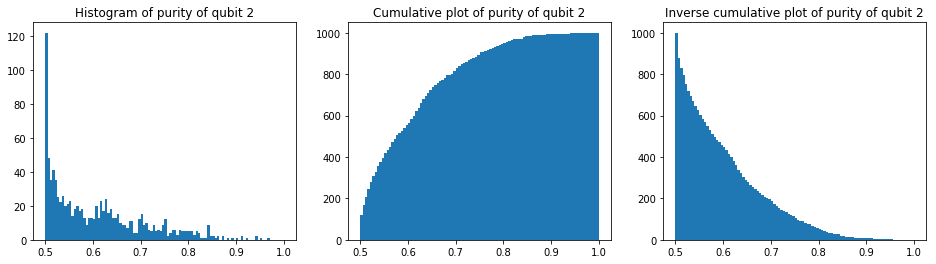

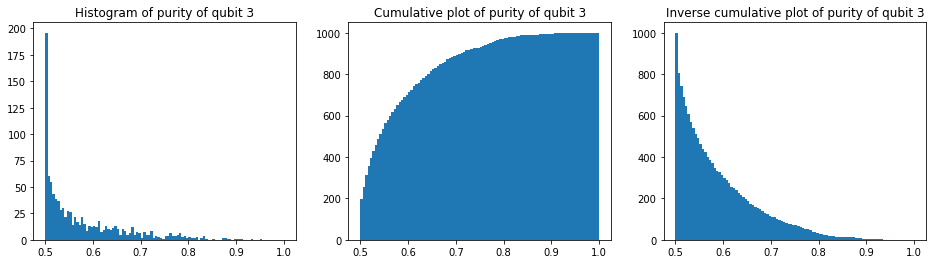

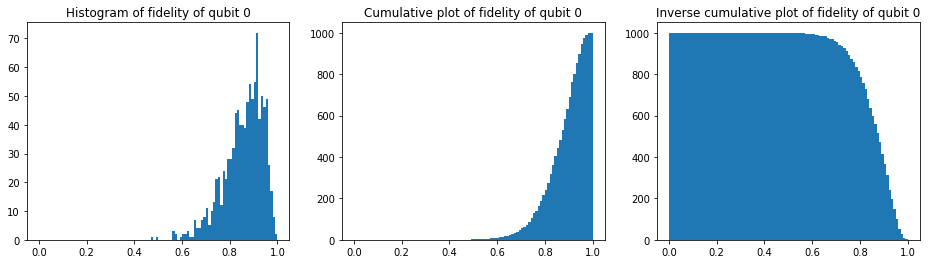

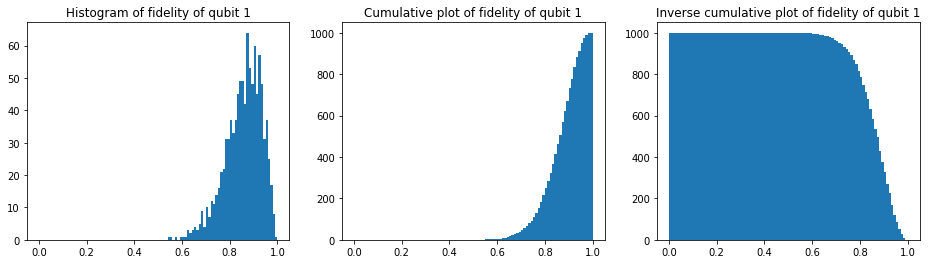

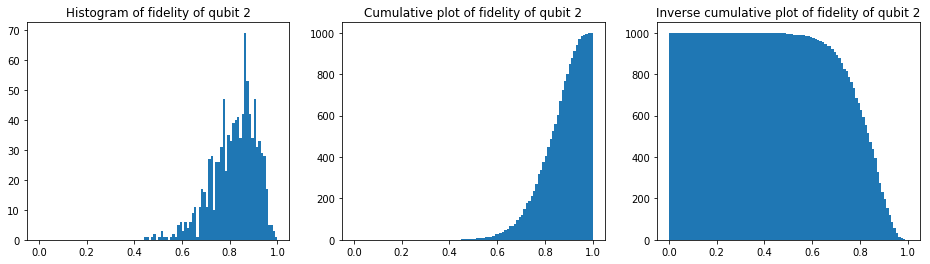

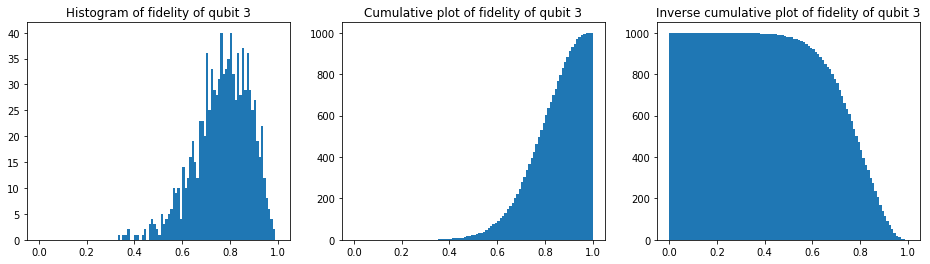





6


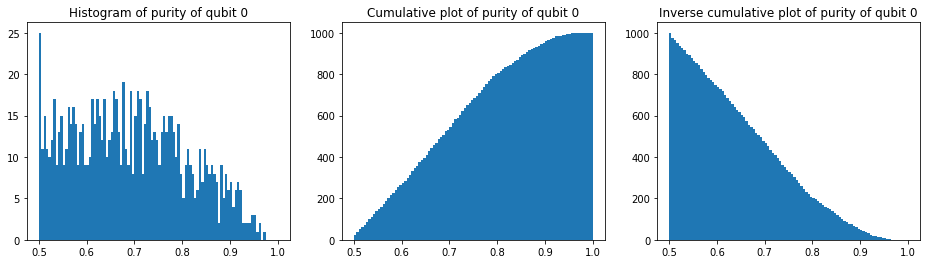

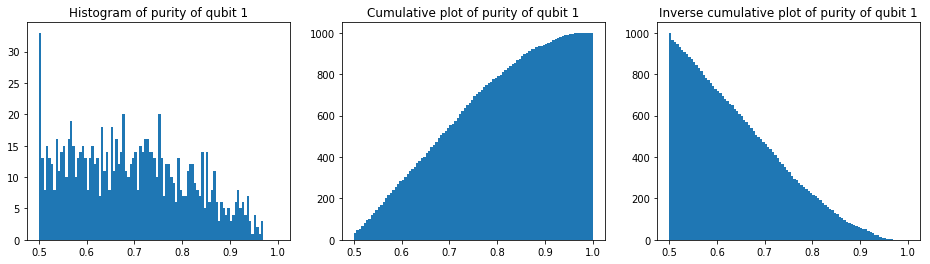

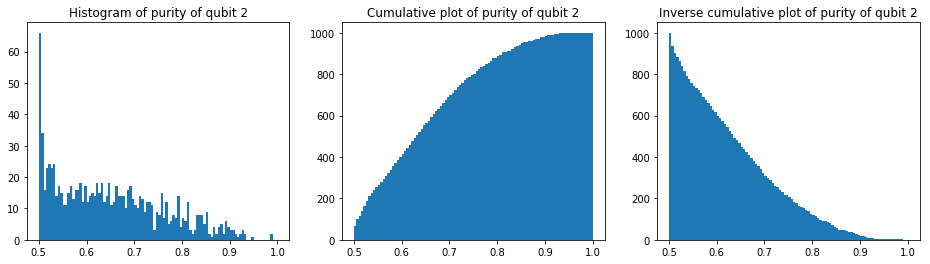

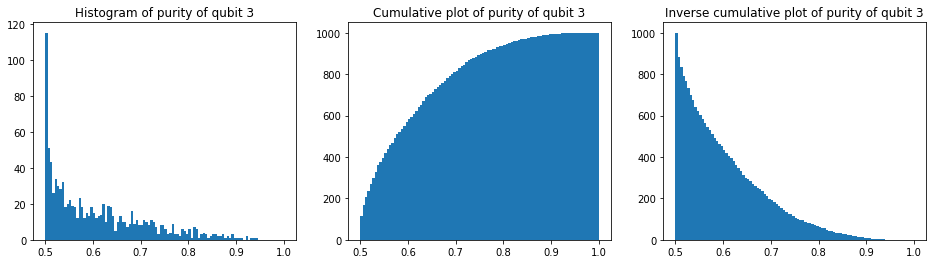

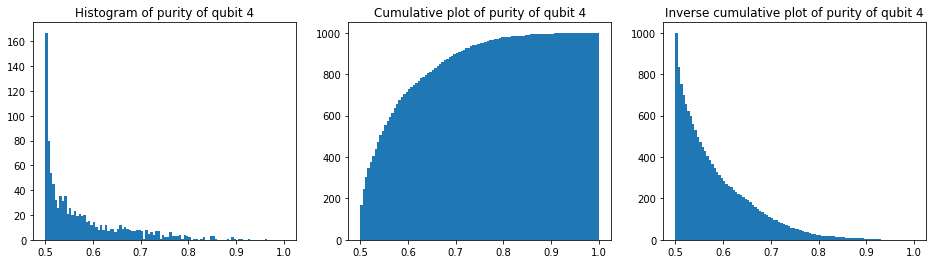

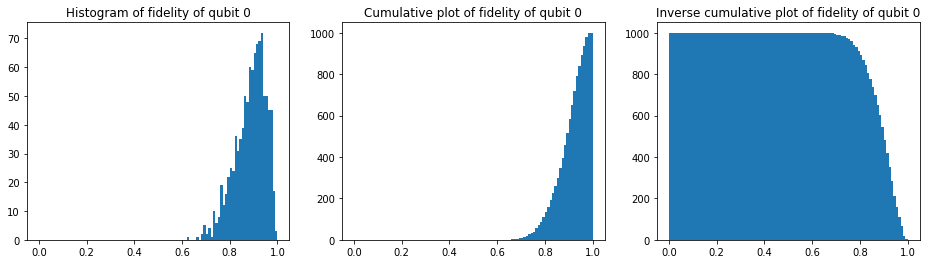

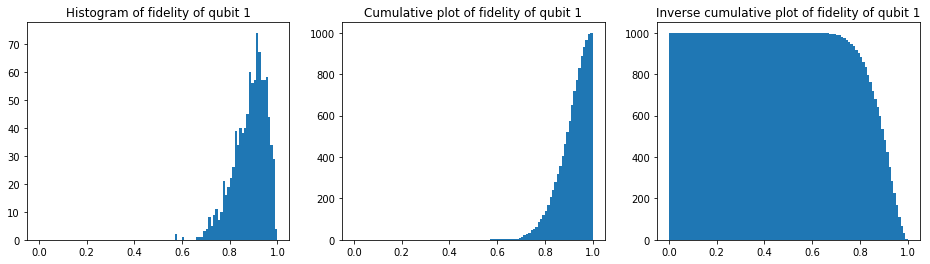

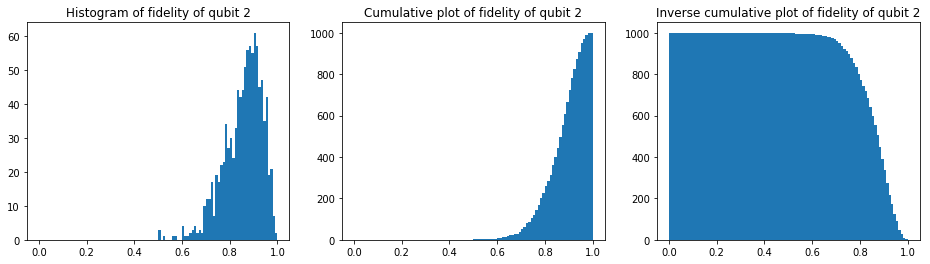

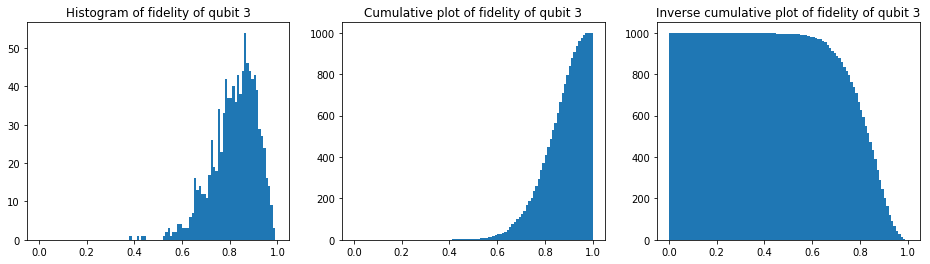

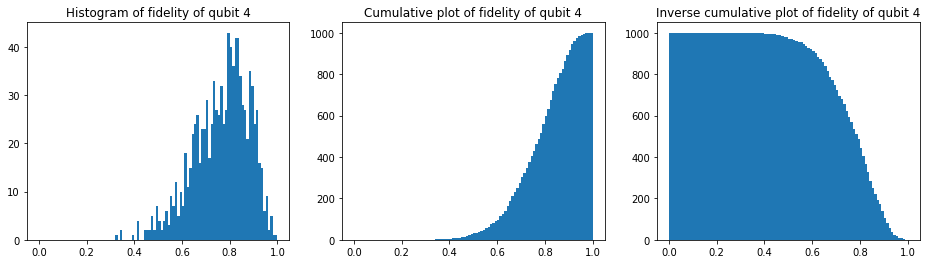





7


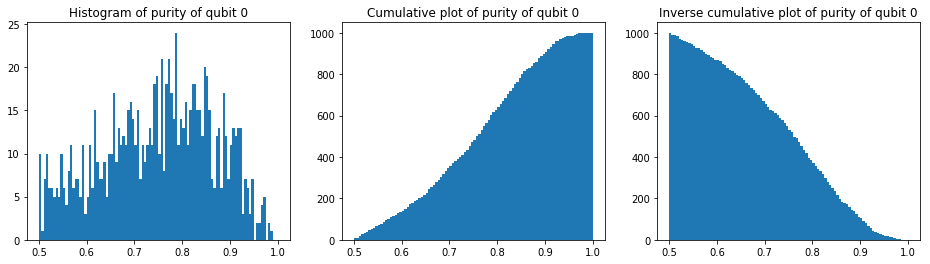

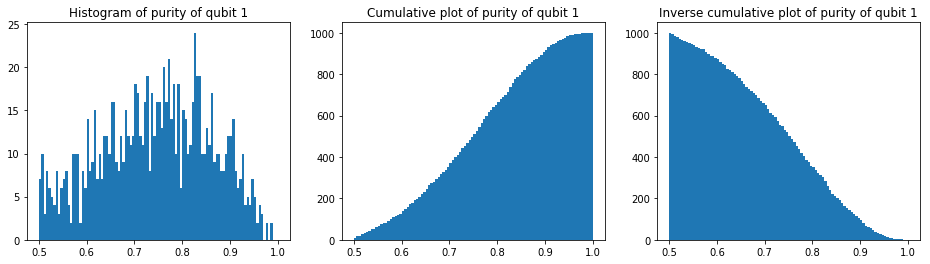

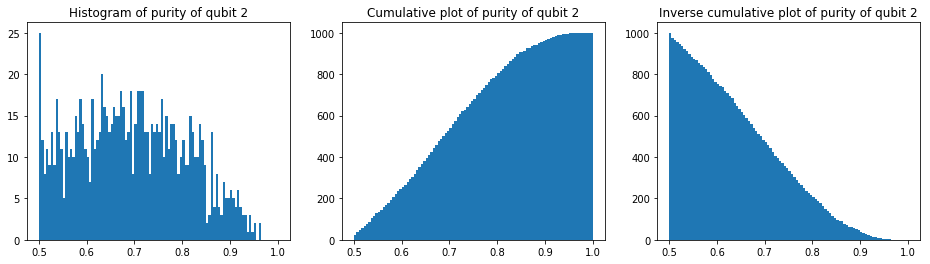

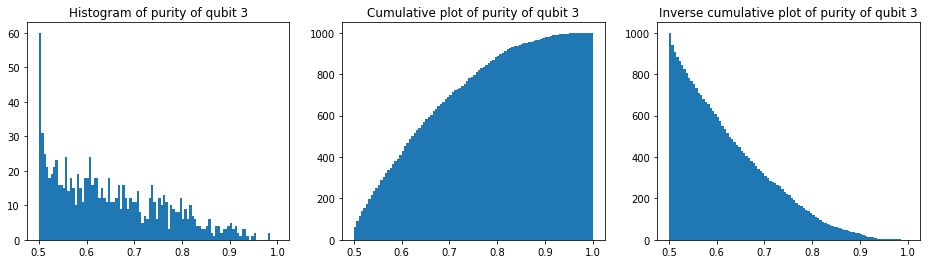

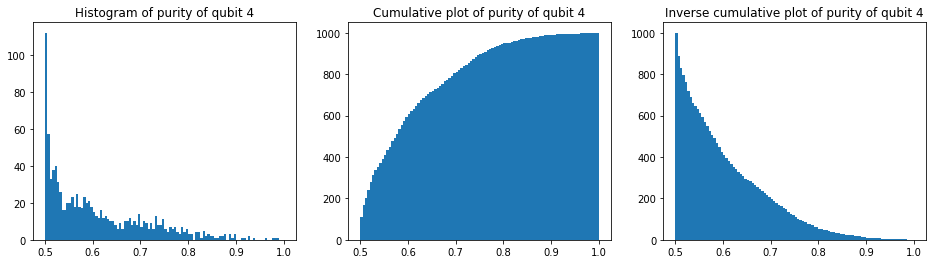

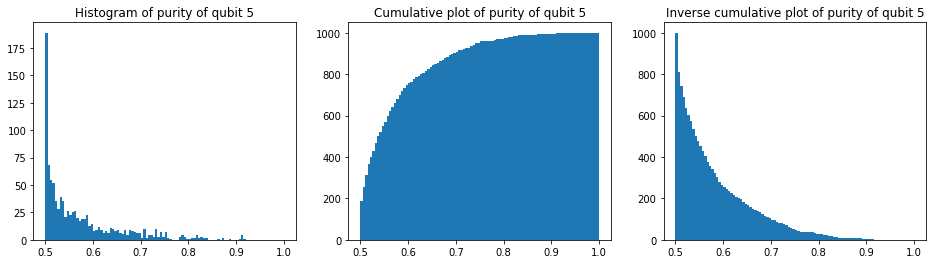

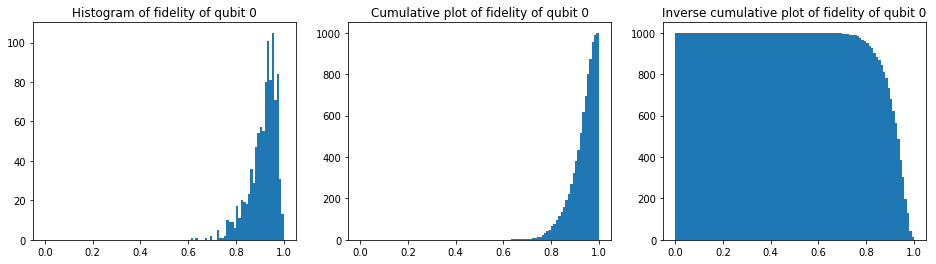

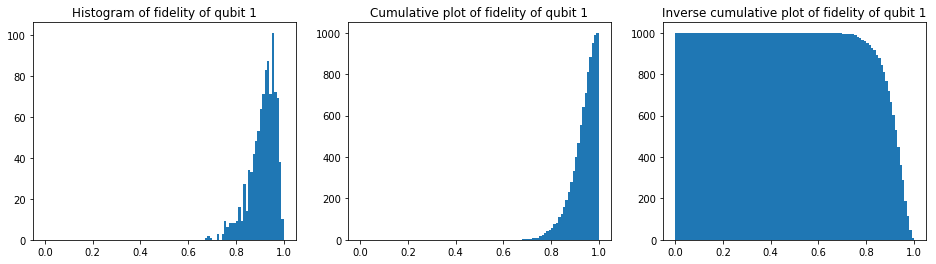

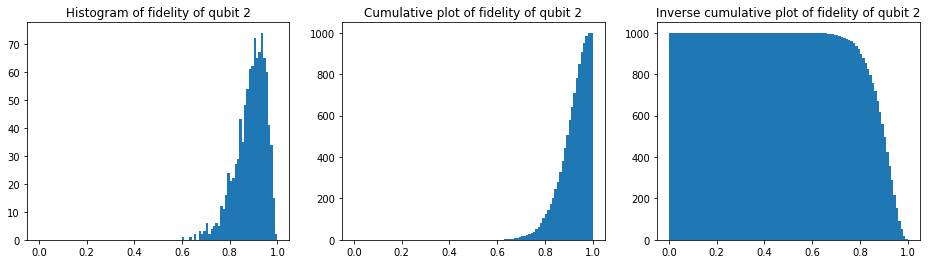

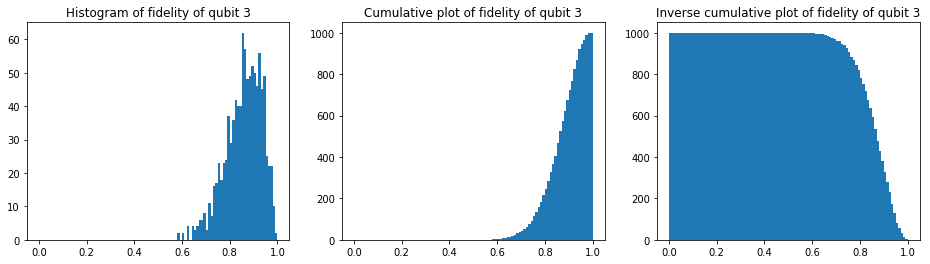

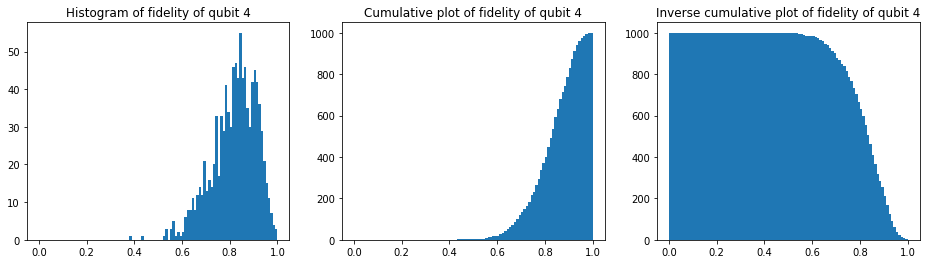

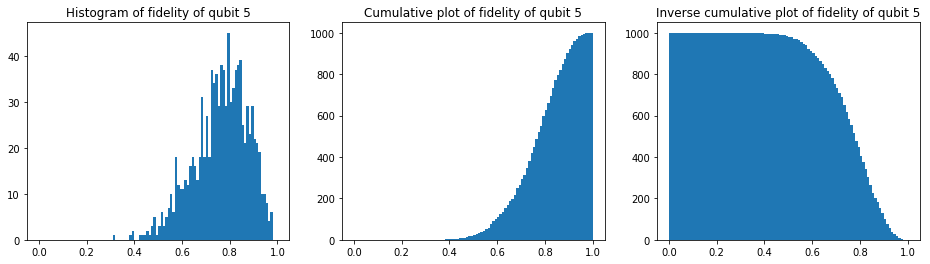





8


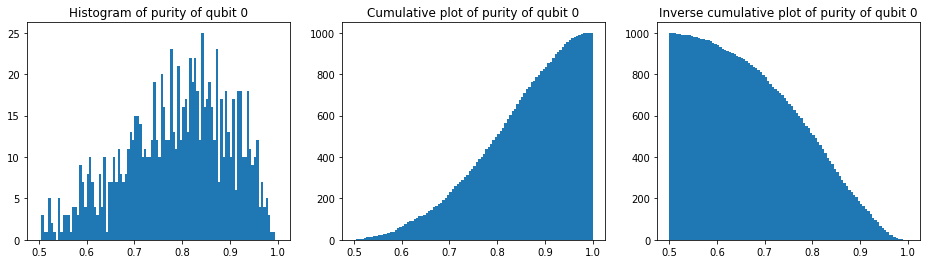

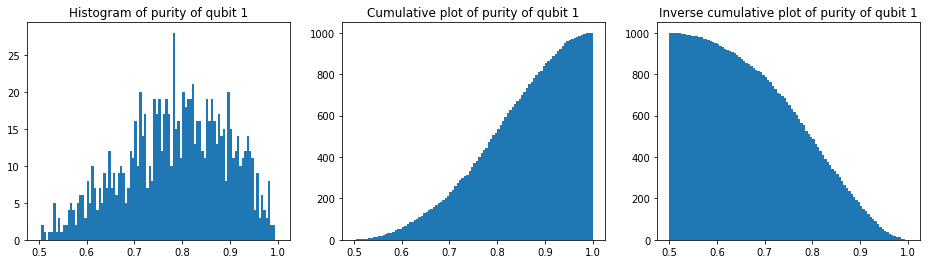

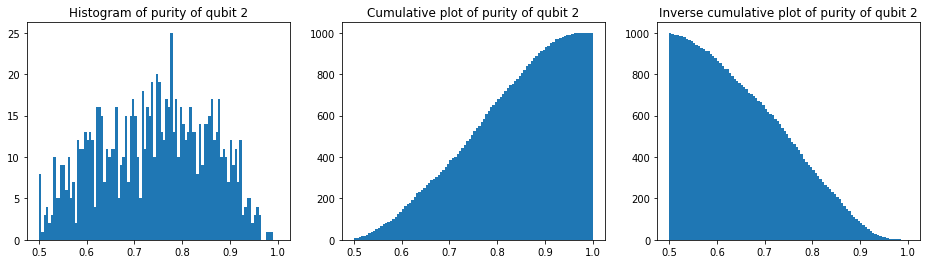

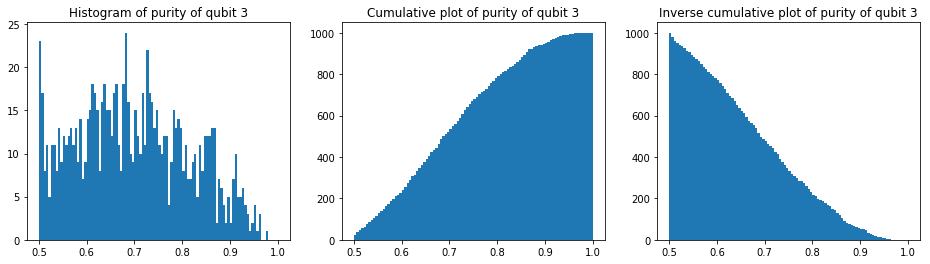

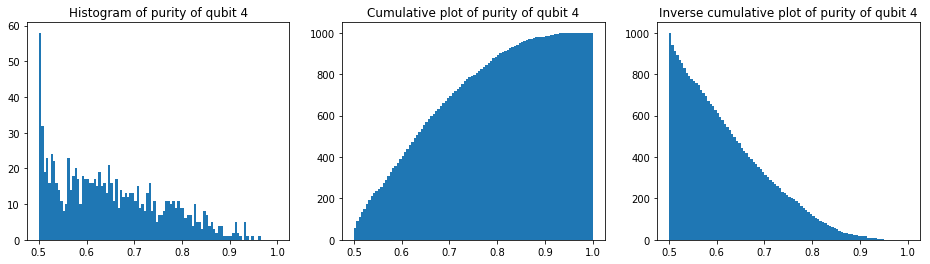

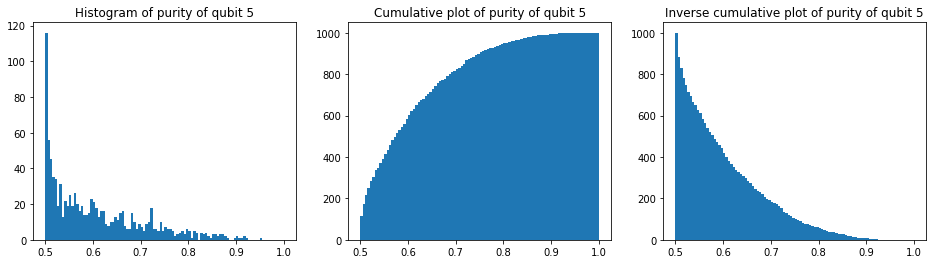

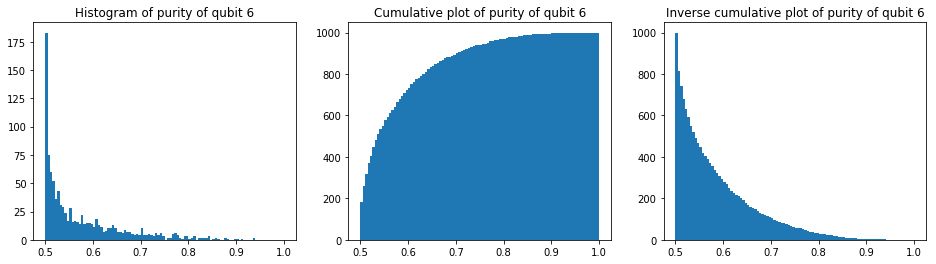

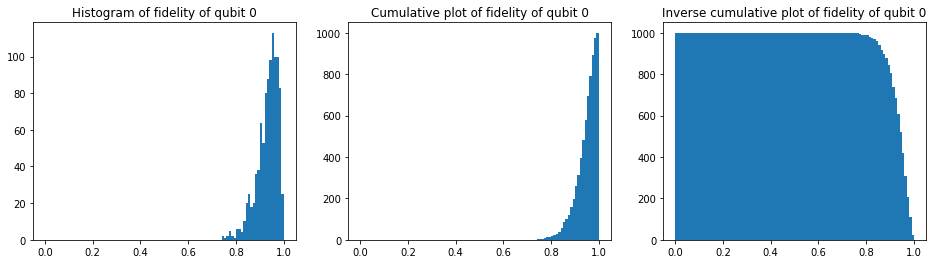

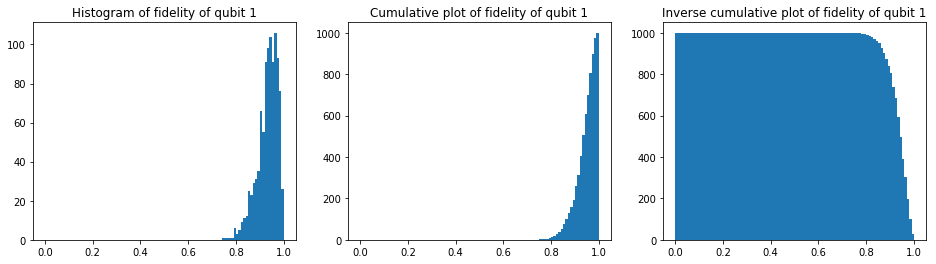

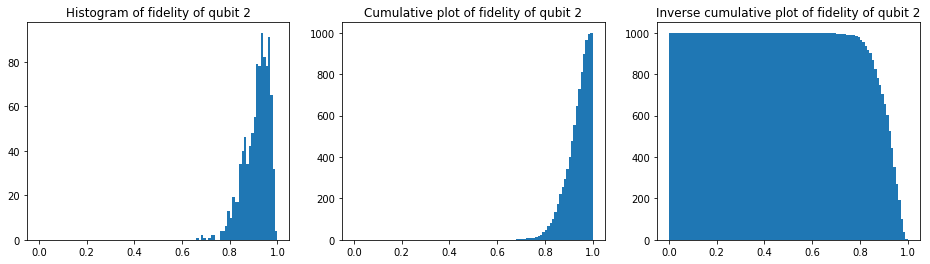

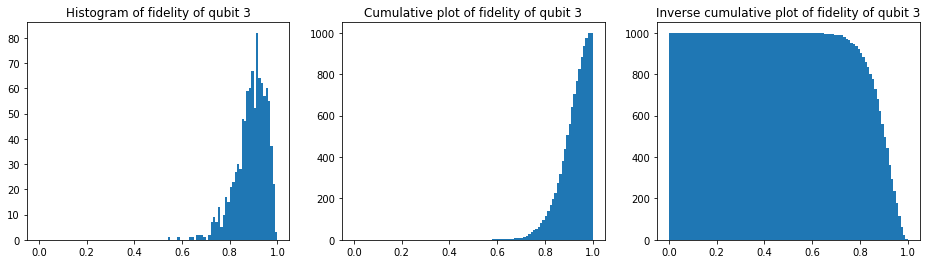

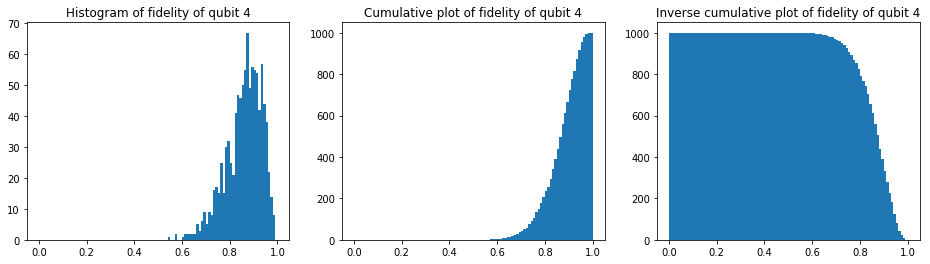

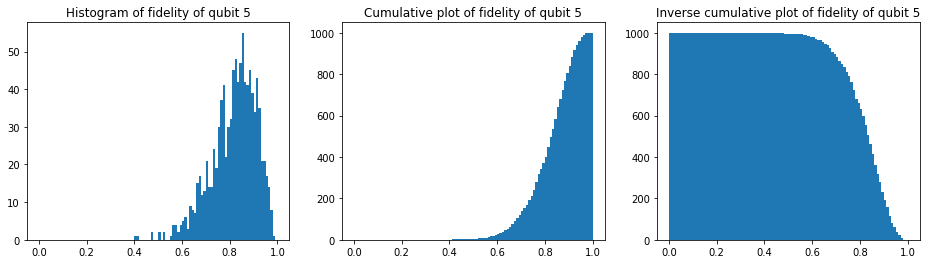

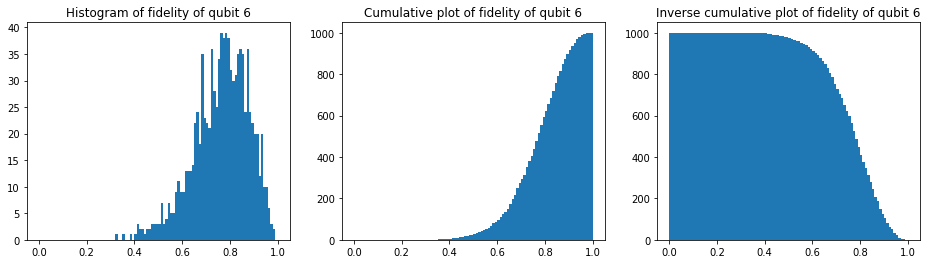





9


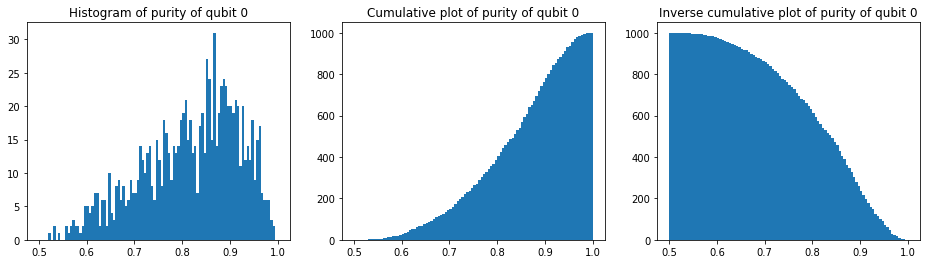

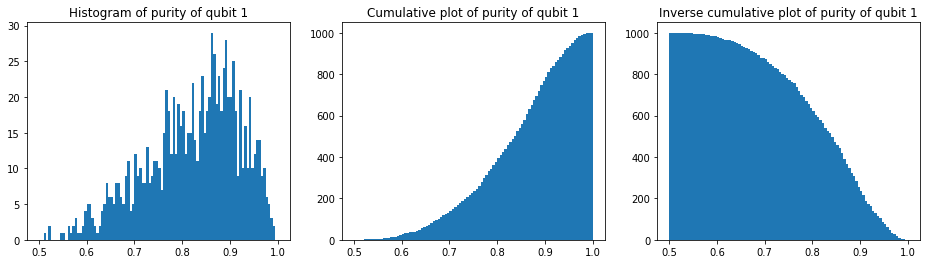

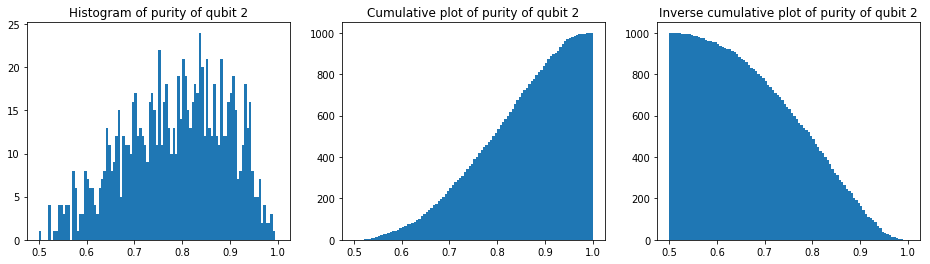

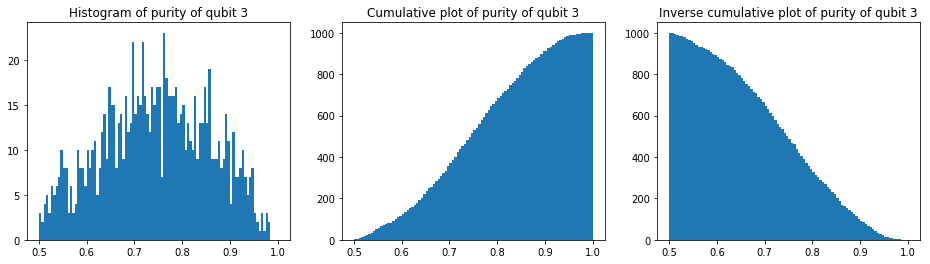

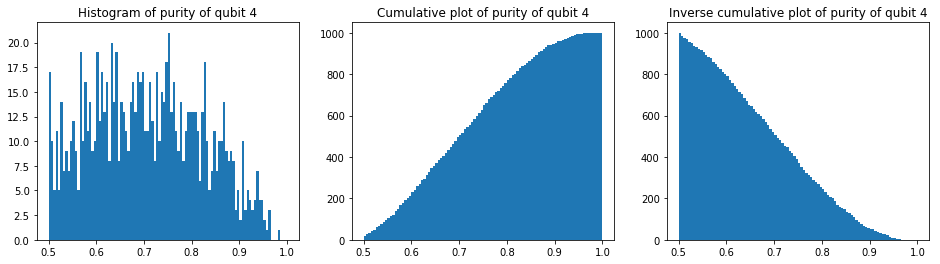

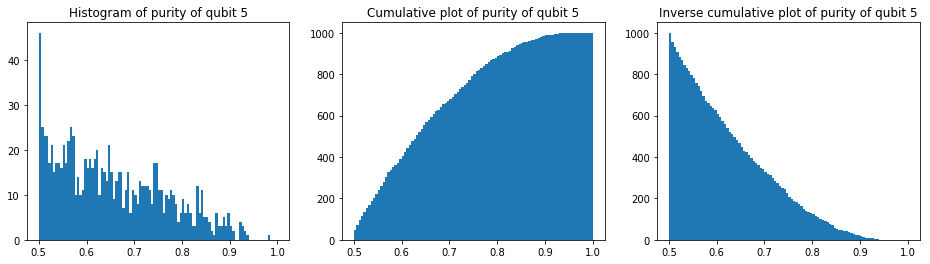

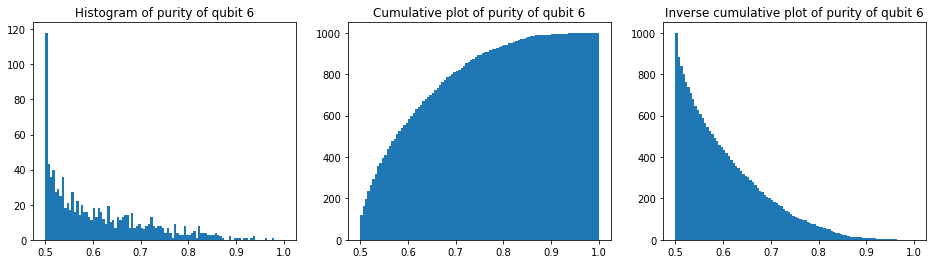

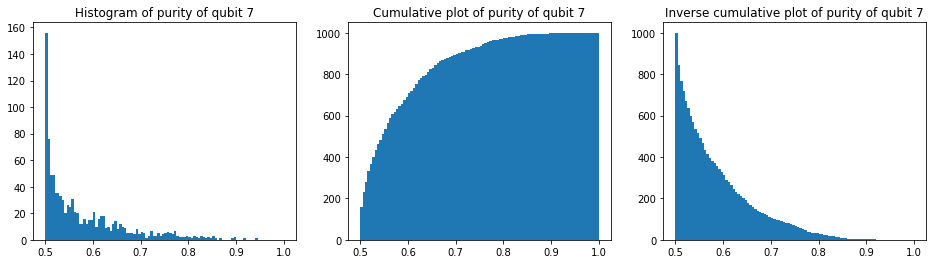

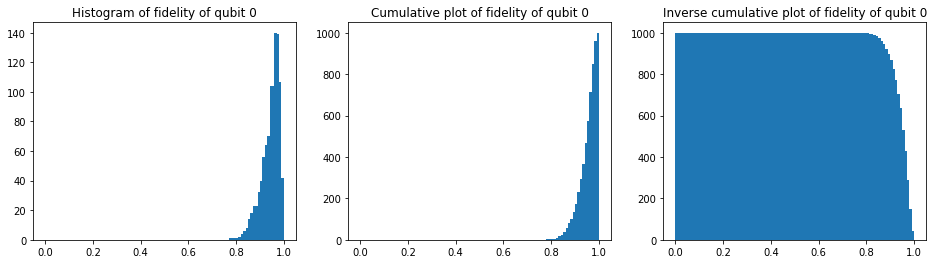

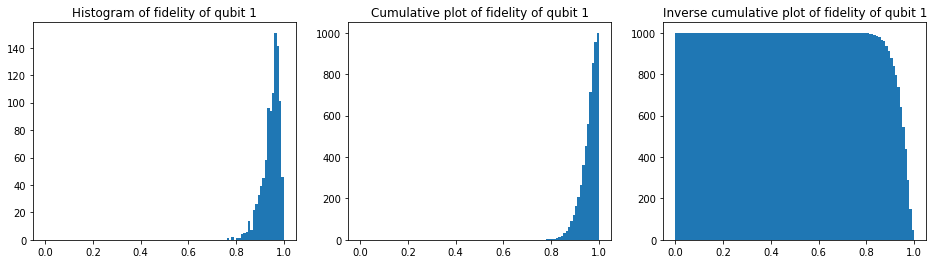

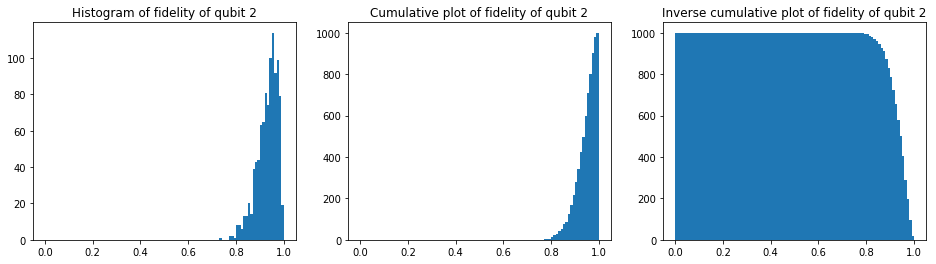

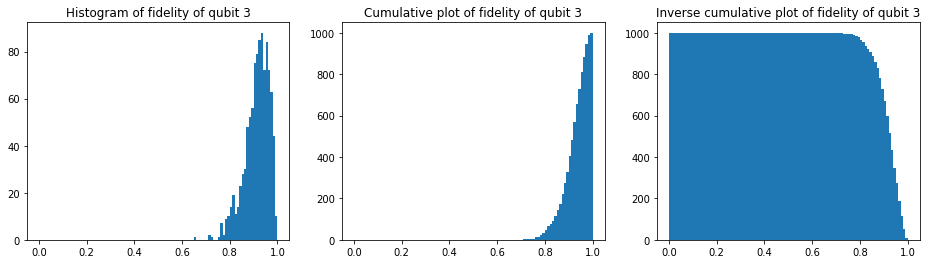

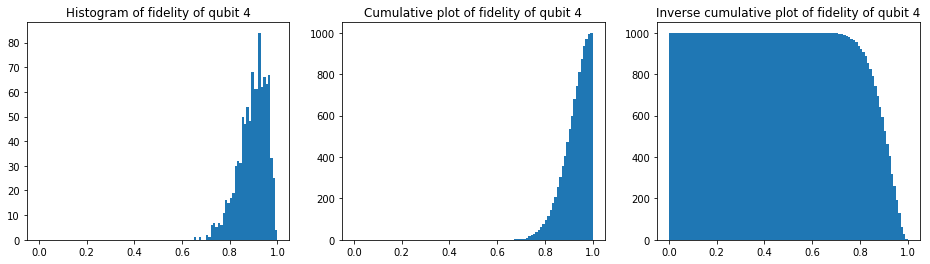

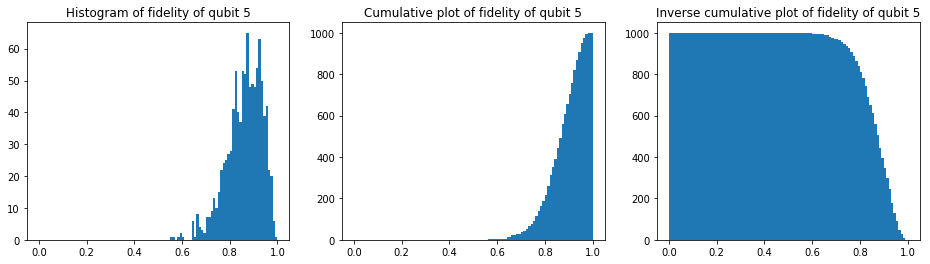

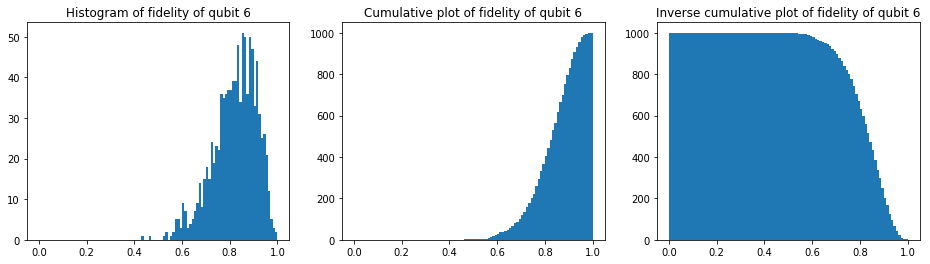

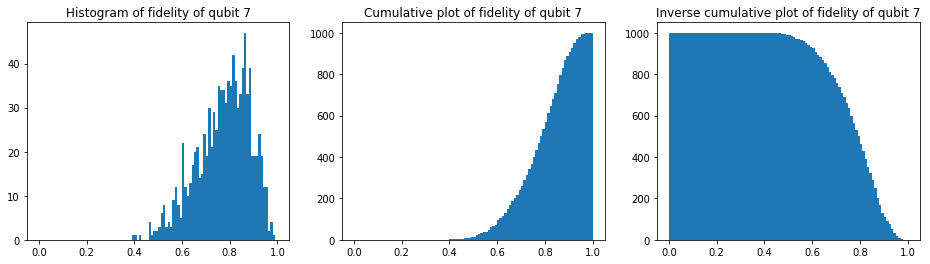





10


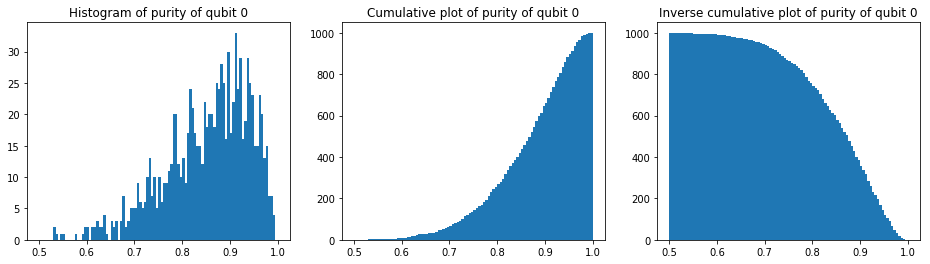

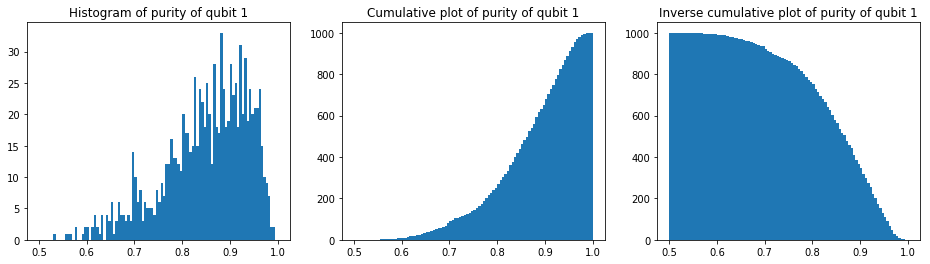

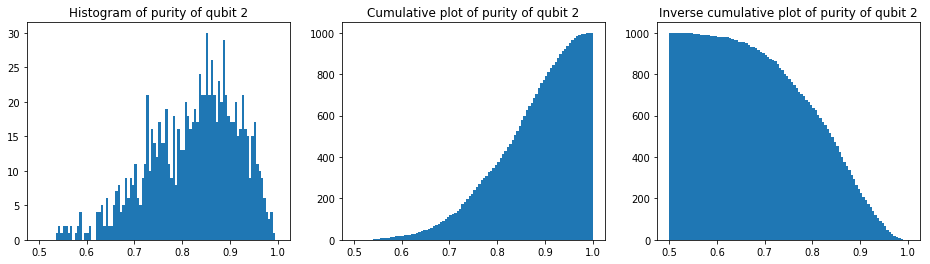

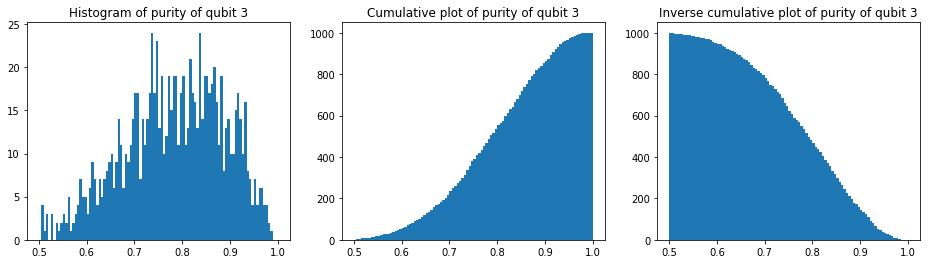

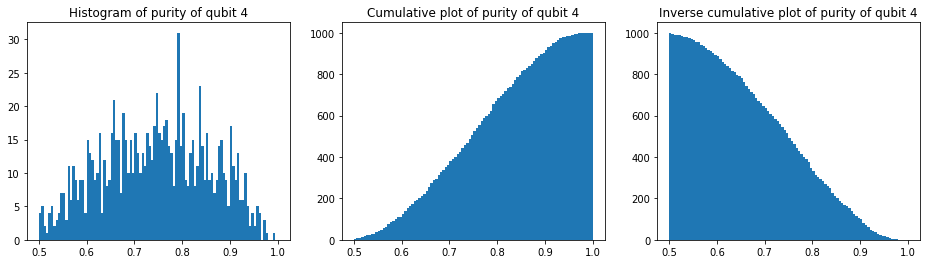

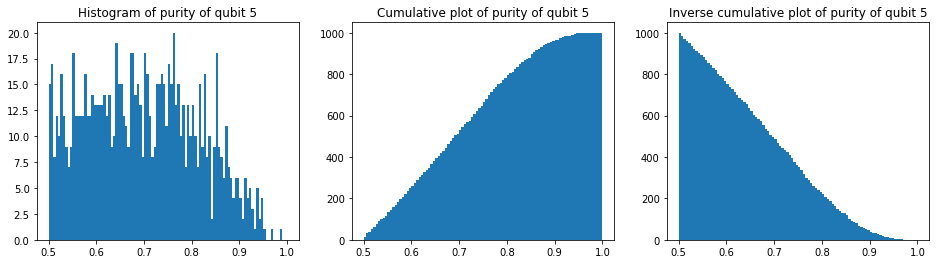

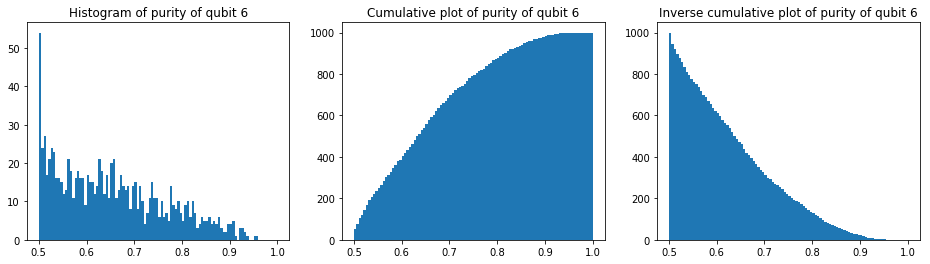

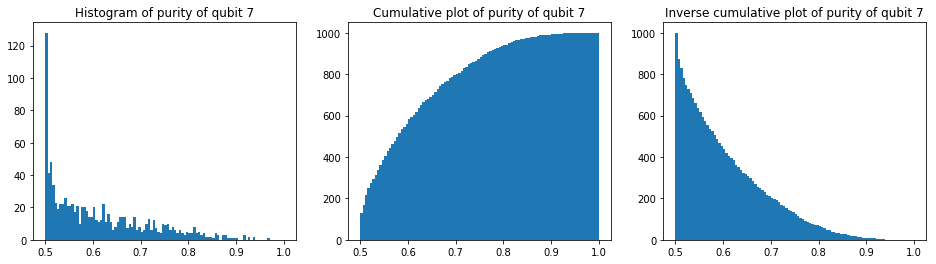

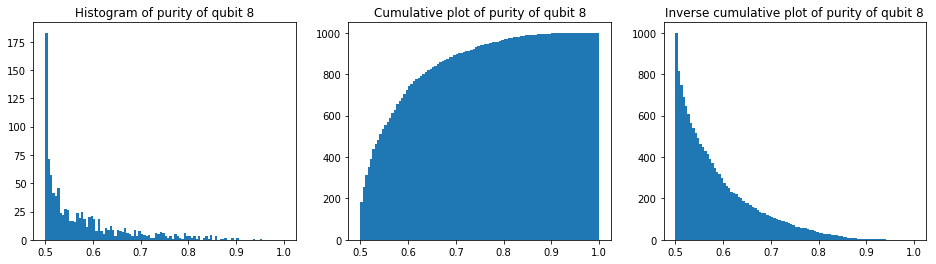

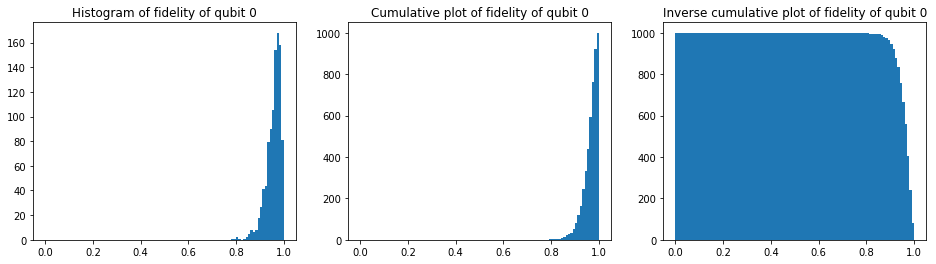

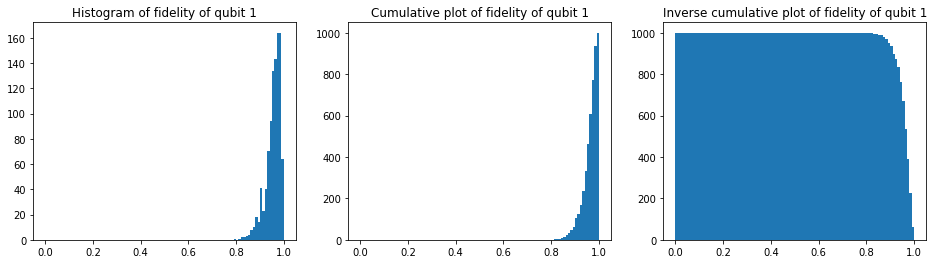

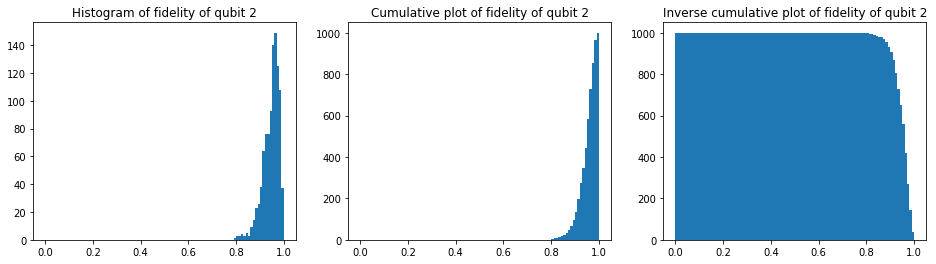

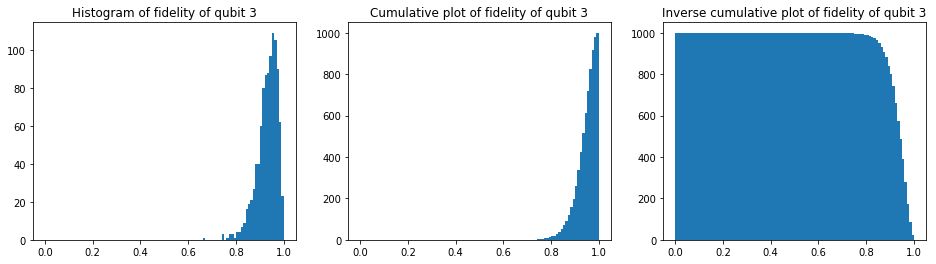

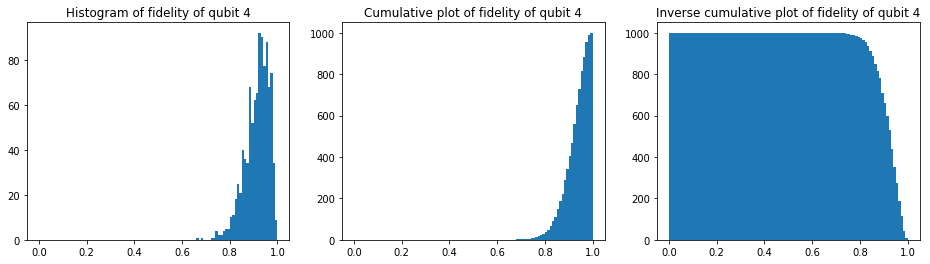

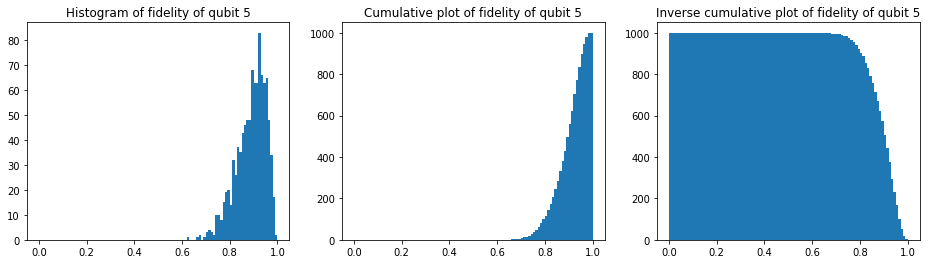

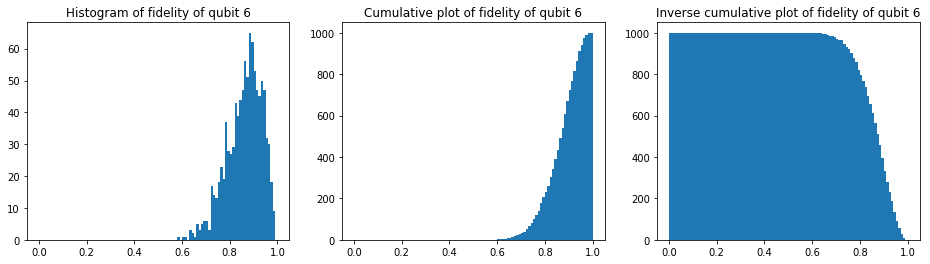

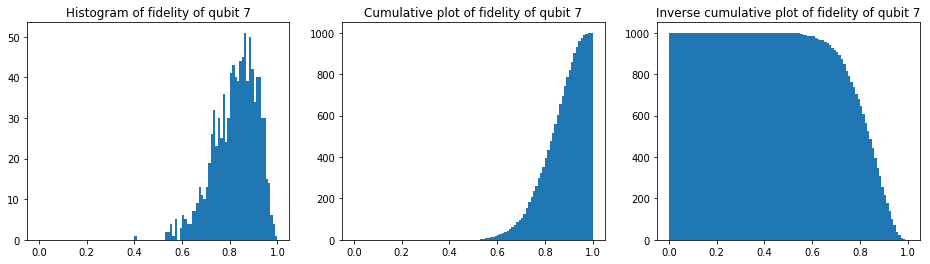

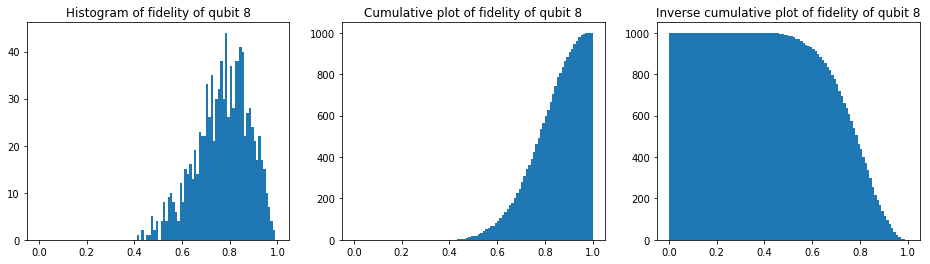

In [807]:
# Running ten circuits of 5 qubits, with gates and initial state chosen randomly

for test_n_qubits in [2, 3, 4, 5, 6, 7, 8, 9, 10]:
    print('\n\n\n')
    n_qubits = test_n_qubits
    print(n_qubits)

    purities = []
    fidelities = []
    
    for i in range(n_qubits - 1):
        purities.append([])
        fidelities.append([])

    for i in range(tot_tries):
        c = cirq.Circuit.from_ops(ladder_shifting([RandomUnitaryGate() for i in range(n_qubits - 1)]))
        random_run = simulator.simulate(c + cirq.inverse(c[:-1]))
        
        for i in range(n_qubits - 1):
            rho0 = cirq.partial_trace(random_run.final_simulator_state.density_matrix, [i]) 
            
            purity0 = np.trace(rho0*rho0)
            purities[i].append(purity0)
            
            fidelities[i].append(fidelity_against_0(rho0))
        
    for i in range(n_qubits - 1):
        purities[i] = np.array(list(map(abs, purities[i])))
        fidelities[i] = np.array(fidelities[i])

    # plot purities 
        
    for i in range(n_qubits - 1):
        
        fig = plt.figure(figsize=[16,4])
        
        ax = fig.add_subplot(1,3,1)

        ax.hist(purities[i], range=(0.5,1), bins=100) 
        ax.set_title('Histogram of purity of qubit ' + str(i))
        
        ax = fig.add_subplot(1,3,2)
        ax.hist(purities[i], range=(0.5,1), bins=100, cumulative=1)
        ax.set_title('Cumulative plot of purity of qubit ' + str(i))
        
        ax = fig.add_subplot(1,3,3)
        ax.hist(purities[i], range=(0.5,1), bins=100, cumulative=-11)
        ax.set_title('Inverse cumulative plot of purity of qubit ' + str(i))
        
        image_name = 'purity_circuit_size_{n_qubits}_qubit_number_{qubit_number}.png'.format(n_qubits = n_qubits, qubit_number = i)
        
        plt.savefig(isaac_images.joinpath(image_name))
        
        plt.show()
        
    make_gif(n_qubits, metric = 'purity') 
    # plot fidelities 
        
    for i in range(n_qubits - 1):
        
        fig = plt.figure(figsize=[16,4])
        
        ax = fig.add_subplot(1,3,1)

        ax.hist(fidelities[i], range=(0,1), bins=100) 
        ax.set_title('Histogram of fidelity of qubit ' + str(i))
        
        ax = fig.add_subplot(1,3,2)
        ax.hist(fidelities[i], range=(0,1), bins=100, cumulative=1)
        ax.set_title('Cumulative plot of fidelity of qubit ' + str(i))
    
        ax = fig.add_subplot(1,3,3)
        ax.hist(fidelities[i], range=(0,1), bins=100, cumulative=-11)
        ax.set_title('Inverse cumulative plot of fidelity of qubit ' + str(i))
        
        image_name = 'fidelity_circuit_size_{n_qubits}_qubit_number_{qubit_number}.png'.format(n_qubits = n_qubits, qubit_number = i)
        
        plt.savefig(isaac_images.joinpath(image_name))
        
        plt.show()
        
    make_gif(n_qubits, metric = 'fidelity')



In [797]:
purity0

(0.75216454+3.6572023e-09j)

In [781]:
qutip.metrics.fidelity?

0.9247057498266744

In [791]:
qutip.Qobj([[0,0]])

Quantum object: dims = [[1], [2]], shape = (1, 2), type = bra
Qobj data =
[[0. 0.]]

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[1.]
 [0.]]

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[ 0.85508072+1.67555947e-09j -0.03893574+6.39357790e-02j]
 [-0.03893571-6.39357641e-02j  0.1449191 +2.73161072e-09j]]

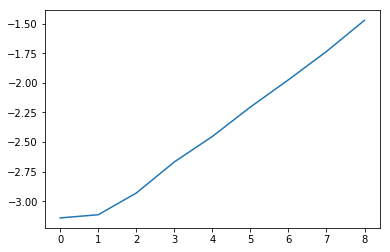

In [822]:
plt.plot(list(map(lambda x: np.log(1-x.mean()),fidelities)))

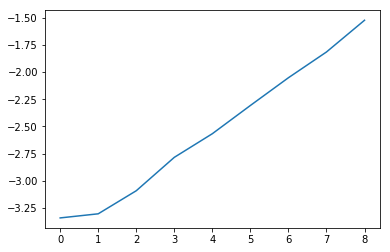

In [827]:
plt.plot(list(map(lambda x: np.log(1-np.median(x)),fidelities)))

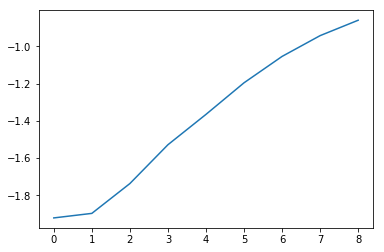

In [823]:
plt.plot(list(map(lambda x: np.log(1-x.mean()),purities)))

In [31]:
import imageio

In [771]:
list(range(8, -1, -1))

[8, 7, 6, 5, 4, 3, 2, 1, 0]

# other 

## 8, 100

In [831]:
c = cirq.Circuit.from_ops(ladder_shared_qubit([RandomUnitaryGate() for i in range(n_qubits - 1)]))

In [832]:
c

0: ───Rnd───Rnd───Rnd───Rnd───Rnd───Rnd───Rnd───Rnd───Rnd───
      │     │     │     │     │     │     │     │     │
1: ───Rnd───┼─────┼─────┼─────┼─────┼─────┼─────┼─────┼─────
            │     │     │     │     │     │     │     │
2: ─────────Rnd───┼─────┼─────┼─────┼─────┼─────┼─────┼─────
                  │     │     │     │     │     │     │
3: ───────────────Rnd───┼─────┼─────┼─────┼─────┼─────┼─────
                        │     │     │     │     │     │
4: ─────────────────────Rnd───┼─────┼─────┼─────┼─────┼─────
                              │     │     │     │     │
5: ───────────────────────────Rnd───┼─────┼─────┼─────┼─────
                                    │     │     │     │
6: ─────────────────────────────────Rnd───┼─────┼─────┼─────
                                          │     │     │
7: ───────────────────────────────────────Rnd───┼─────┼─────
                                                │     │
8: ─────────────────────────────────────────────Rnd───┼─────
                                                      │
9: ───────────────────────────────────────────────────Rnd───

In [833]:
c = cirq.Circuit.from_ops(ladder_shifting([RandomUnitaryGate() for i in range(n_qubits - 1)]))

In [834]:
c

0: ───Rnd───────────────────────────────────────────────────
      │
1: ───Rnd───Rnd─────────────────────────────────────────────
            │
2: ─────────Rnd───Rnd───────────────────────────────────────
                  │
3: ───────────────Rnd───Rnd─────────────────────────────────
                        │
4: ─────────────────────Rnd───Rnd───────────────────────────
                              │
5: ───────────────────────────Rnd───Rnd─────────────────────
                                    │
6: ─────────────────────────────────Rnd───Rnd───────────────
                                          │
7: ───────────────────────────────────────Rnd───Rnd─────────
                                                │
8: ─────────────────────────────────────────────Rnd───Rnd───
                                                      │
9: ───────────────────────────────────────────────────Rnd───

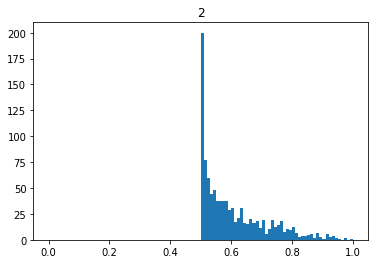

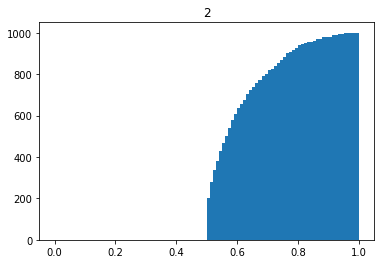

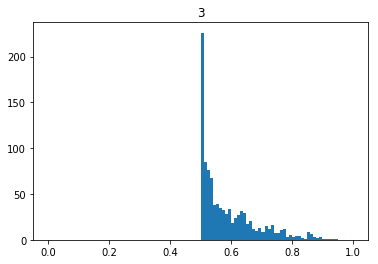

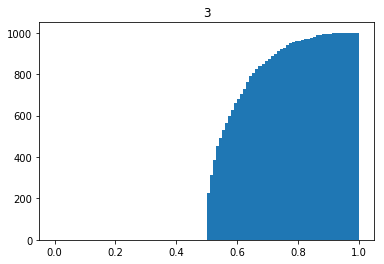

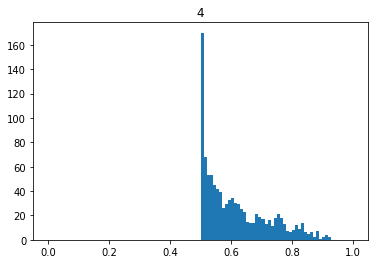

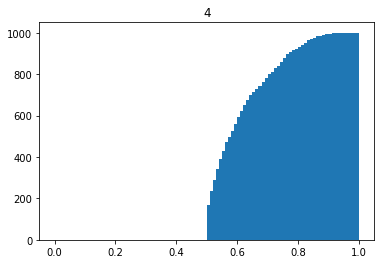

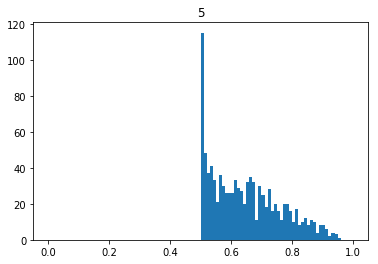

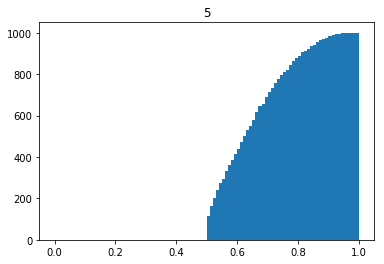

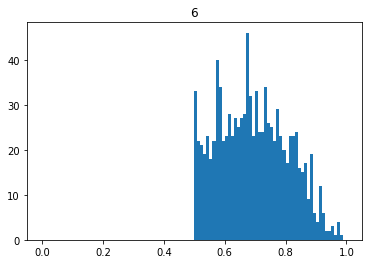

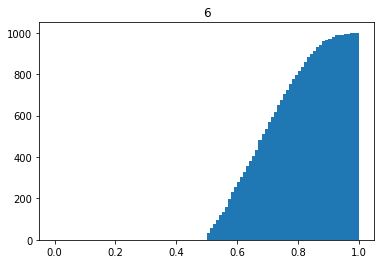

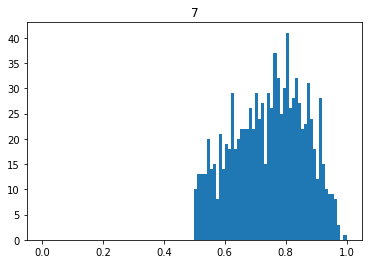

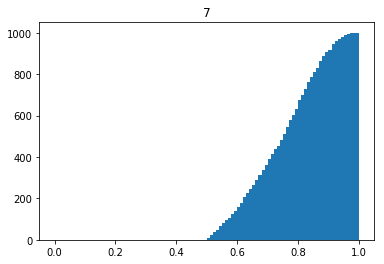

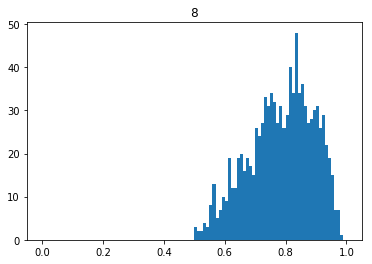

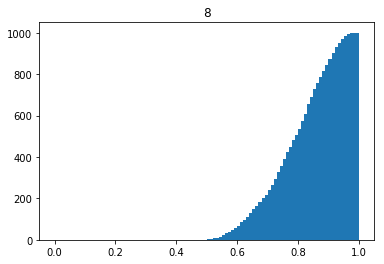

In [686]:
# Running ten circuits of 5 qubits, with gates and initial state chosen randomly
for test_n_qubits in [8]:
    n_qubits = test_n_qubits
    
    puritiesB = []

    for i in range(tot_tries):
        c = cirq.Circuit.from_ops(ladder_shifting([RandomUnitaryGate() for i in range(n_qubits - 1)]))
        random_run = simulator.simulate(c + cirq.inverse(c[:-1]))
        rho0 = cirq.partial_trace(random_run.final_simulator_state.density_matrix, [0]) 
        # Reduced density matrix of first qubit
        purity0 = np.trace(rho0*rho0)
        #print('overlap:',random_run.final_state[0]) # Should be <rho|0^n>
        #print('purity:',purity0)
        puritiesB.append(purity0)

    pB = np.array(list(map(abs, puritiesB)))

    plt.hist(pB, range=(0,1), bins=100)
    plt.title(str(test_n_qubits))
    plt.show()
    
    plt.hist(pB, range=(0,1), bins=100, cumulative=1)
    plt.title(str(test_n_qubits))
    plt.show()
    

In [721]:
import os

import pathlib

In [750]:
isaac_folder = pathlib.Path.cwd()
isaac_images = isaac_folder.joinpath('images')
isaac_images.mkdir(parents = True, exist_ok = True)

In [753]:
plt.savefig(isaac_images.joinpath('test.png'))

<Figure size 432x288 with 0 Axes>

In [32]:
def make_gif(n_qubits, metric):
    images = []
    unformated_name = '{metric}_circuit_size_{n_qubits}_qubit_number_{qubit_number}.png'
    for i in range(0, n_qubits - 1):
        image_name = unformated_name.format(metric = metric, n_qubits = n_qubits, qubit_number = i)

        images.append(imageio.imread(isaac_images.joinpath(image_name)))

    for i in range(n_qubits - 2, -1, -1):
        image_name = unformated_name.format(metric = metric, n_qubits = n_qubits, qubit_number = i)

        images.append(imageio.imread(isaac_images.joinpath(image_name)))

    gif_name = '{metric}_circuit_size_{n_qubits}_compiled.gif'.format(metric = metric, n_qubits = n_qubits)
    imageio.mimsave(isaac_images.joinpath(gif_name), images)

In [33]:
def fidelity_against_0(rho):
    return qutip.metrics.fidelity(qutip.Qobj(rho),qutip.basis(2,0))





2


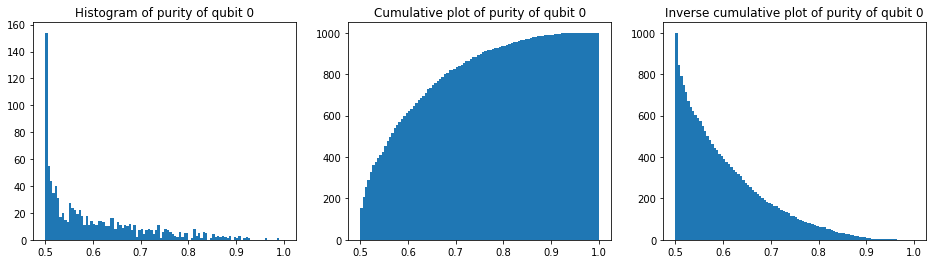

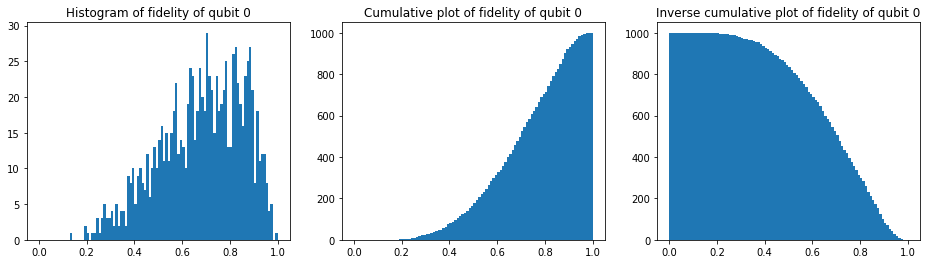





3


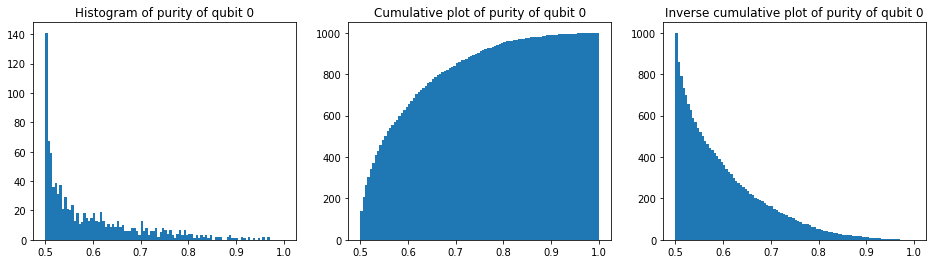

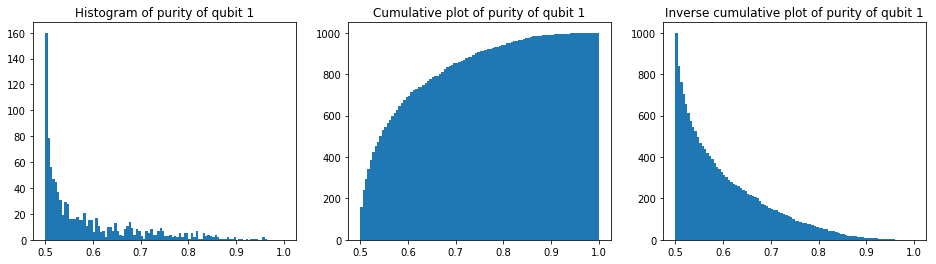

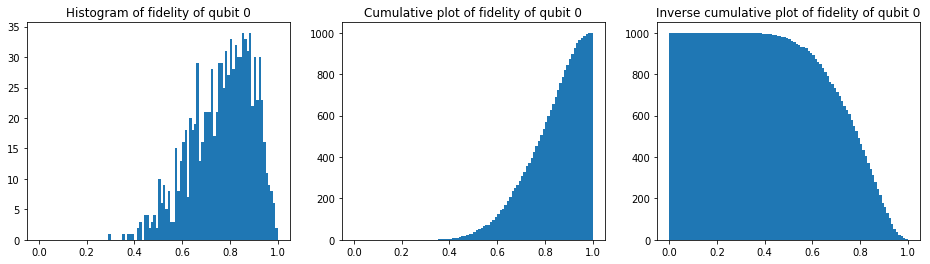

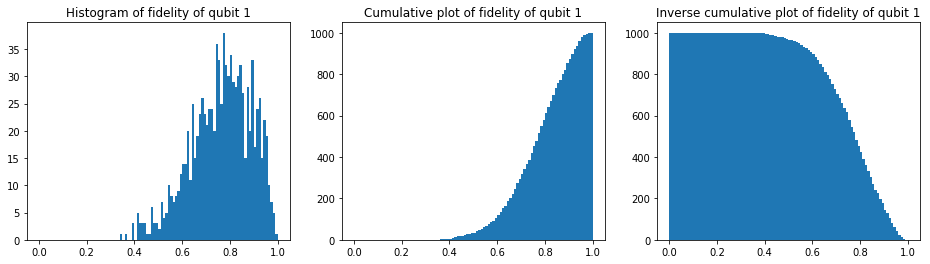





4


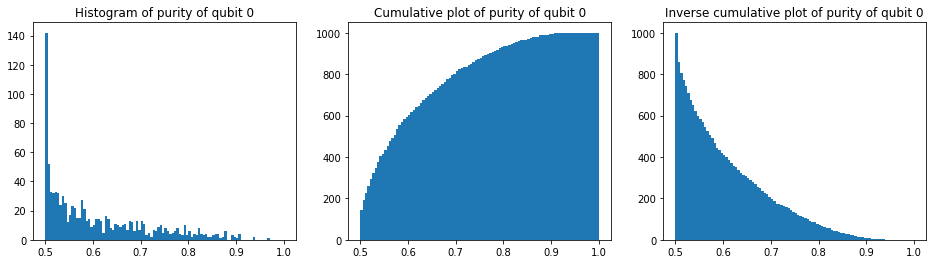

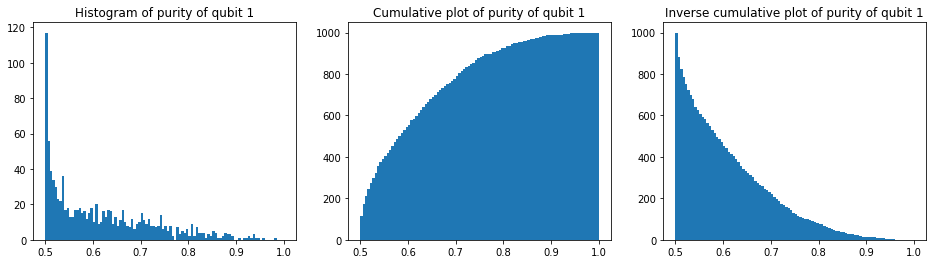

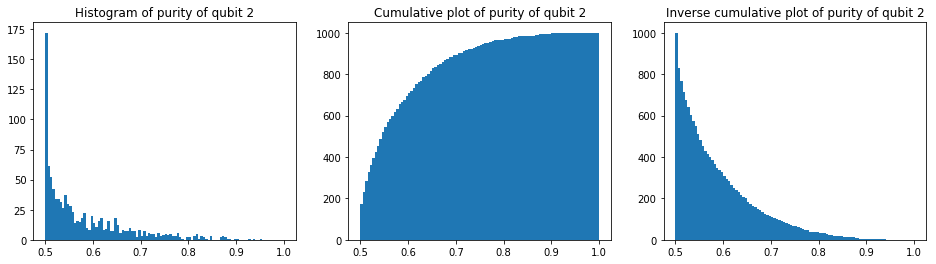

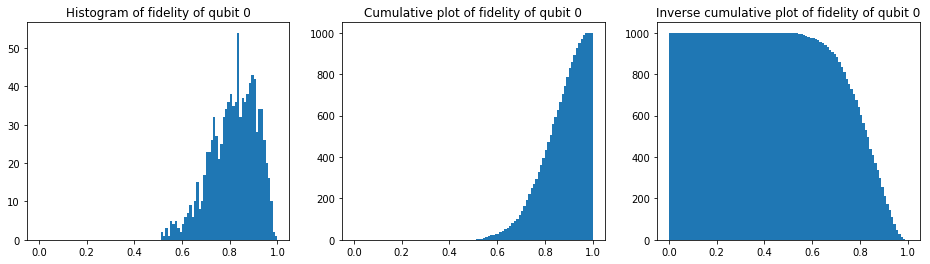

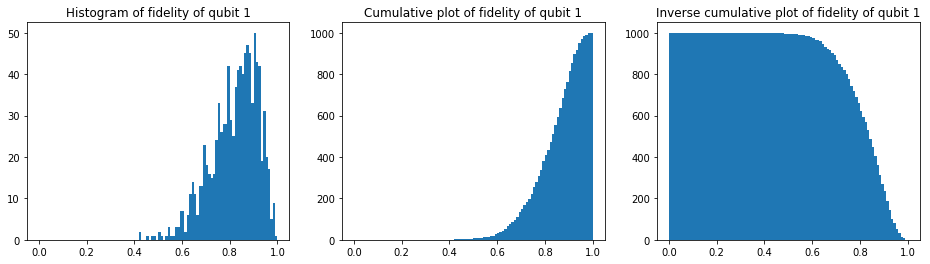

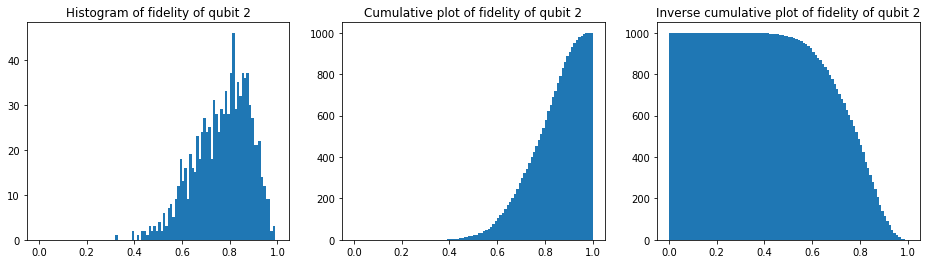





5


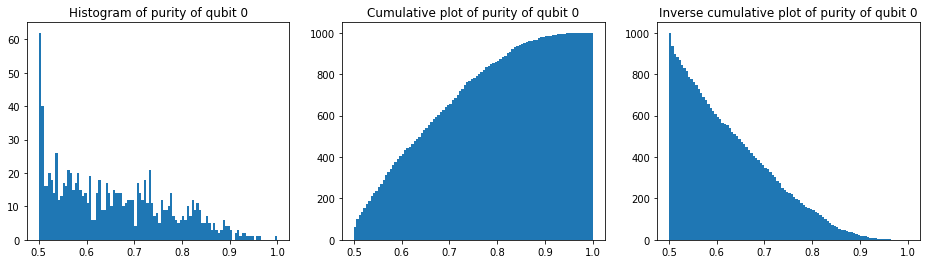

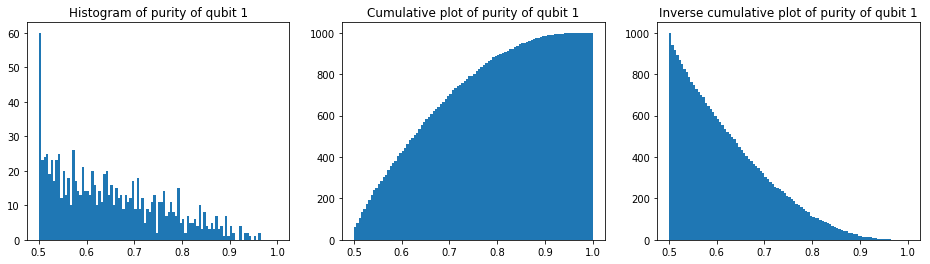

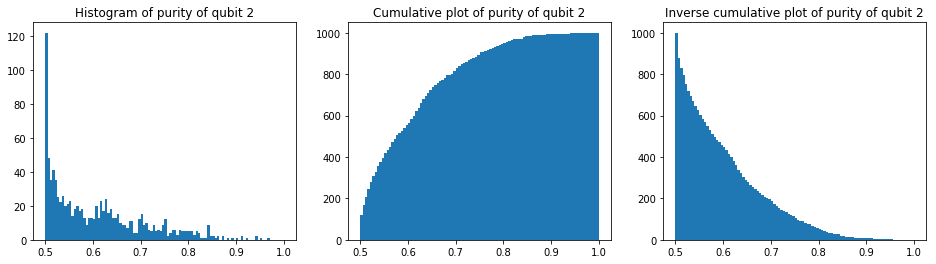

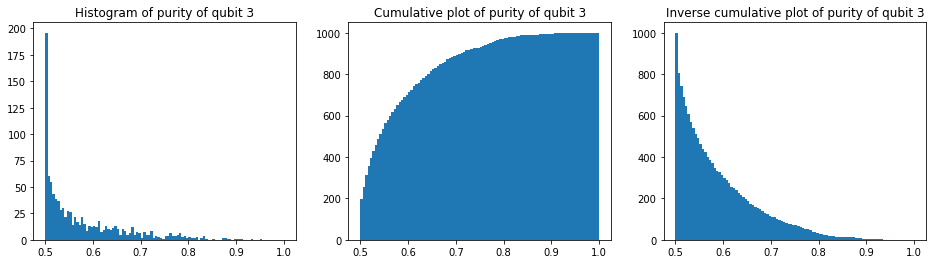

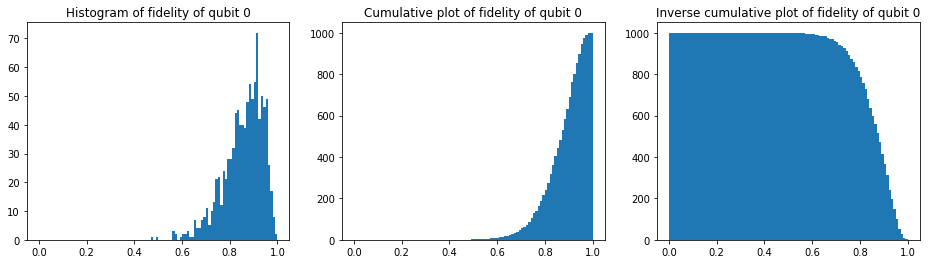

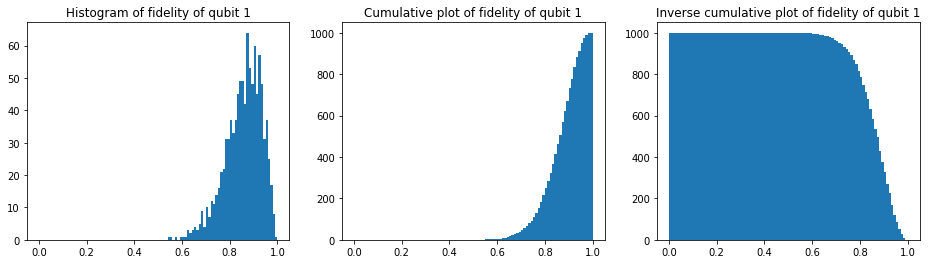

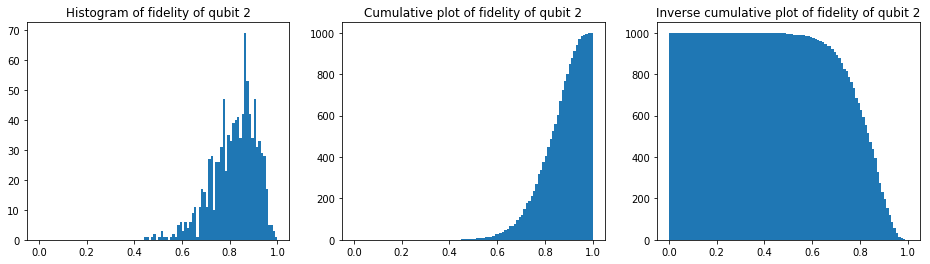

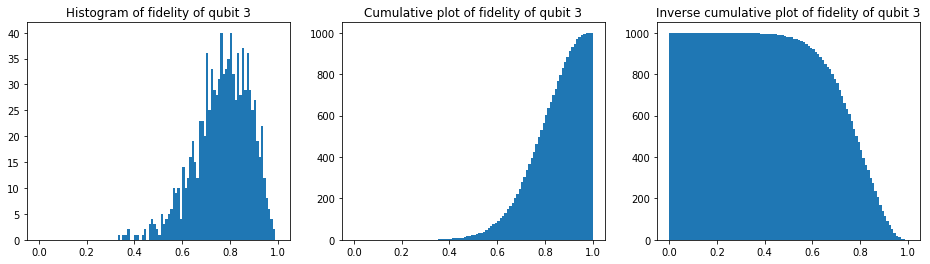





6


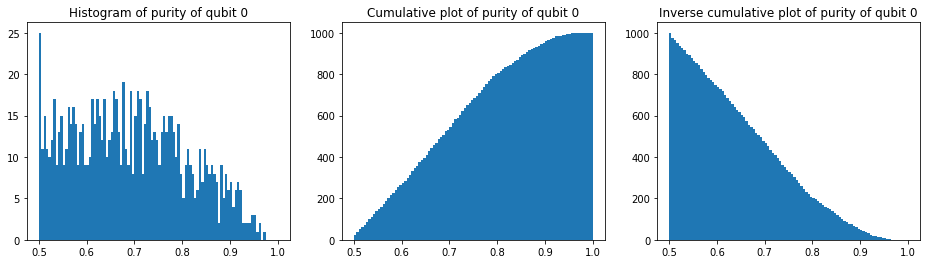

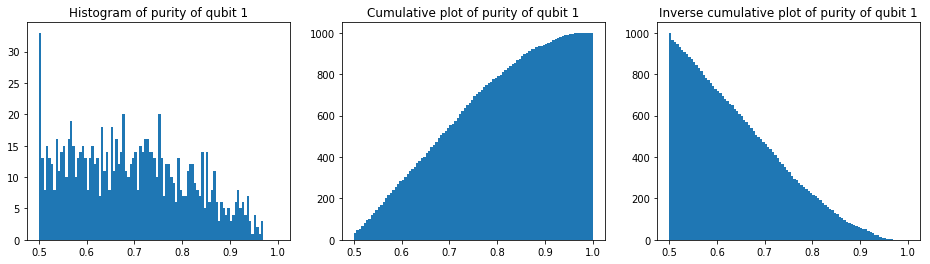

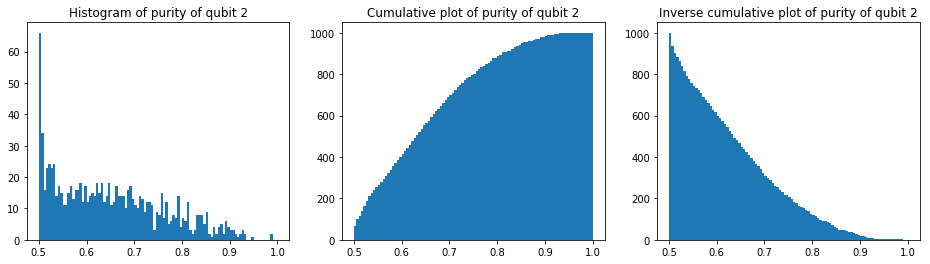

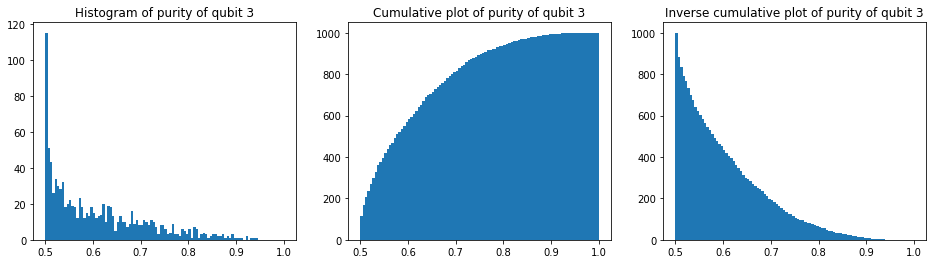

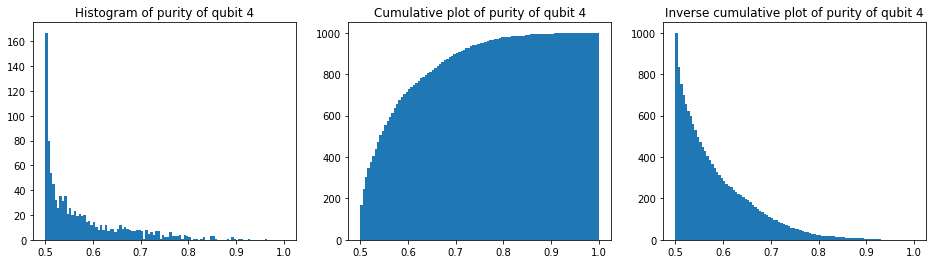

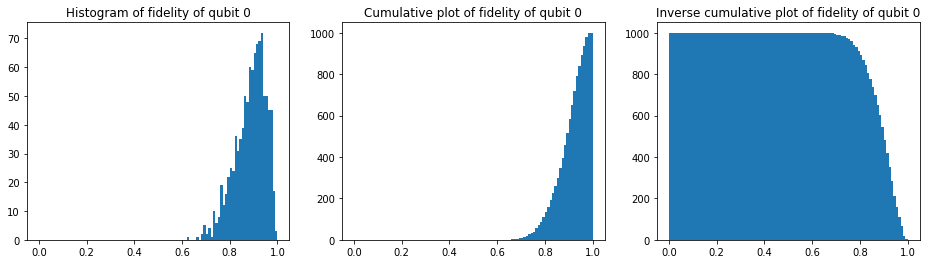

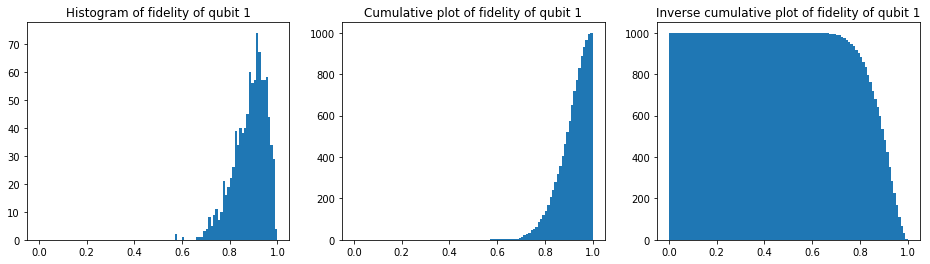

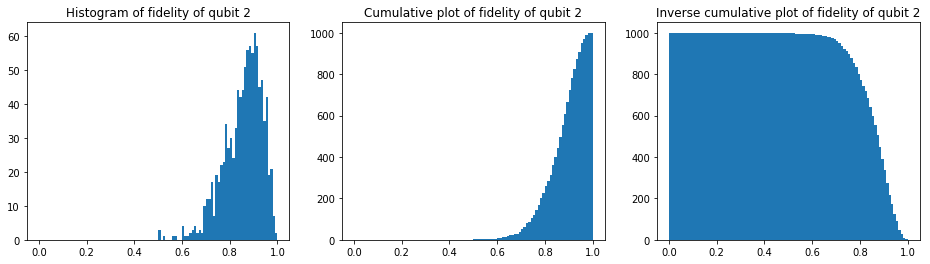

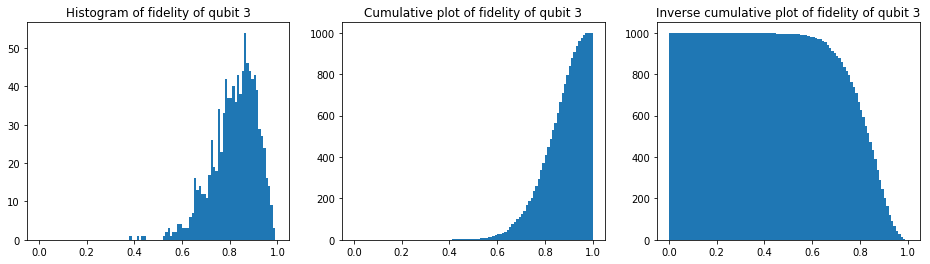

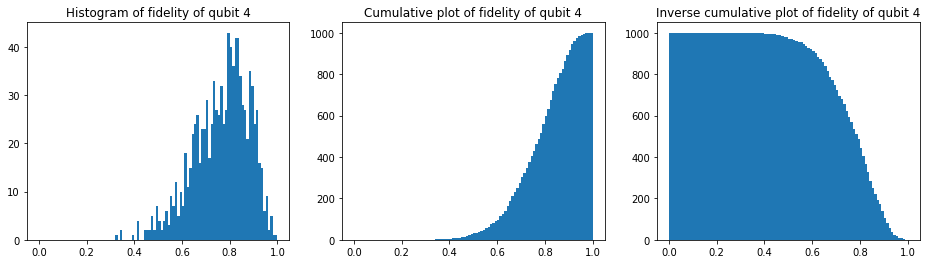





7


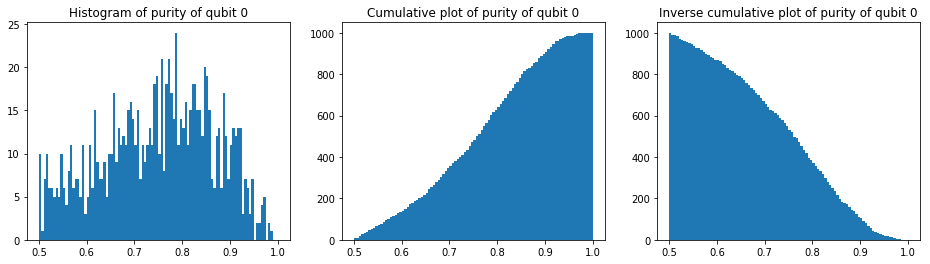

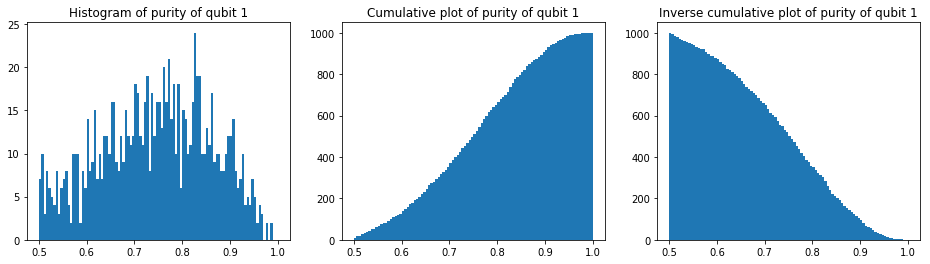

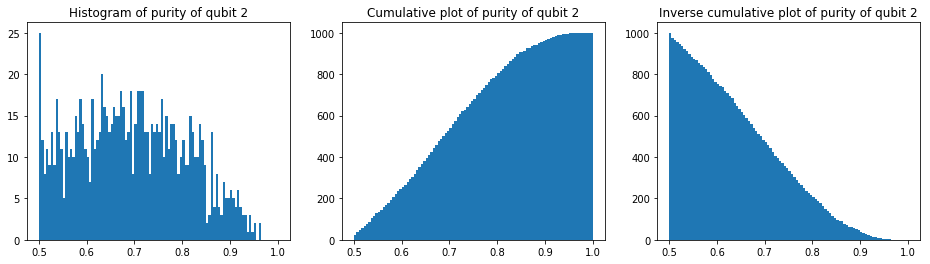

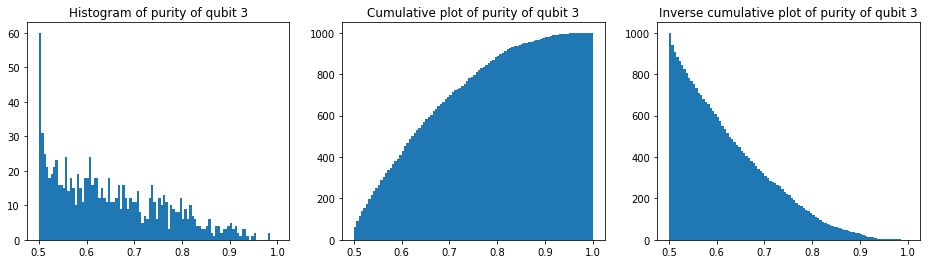

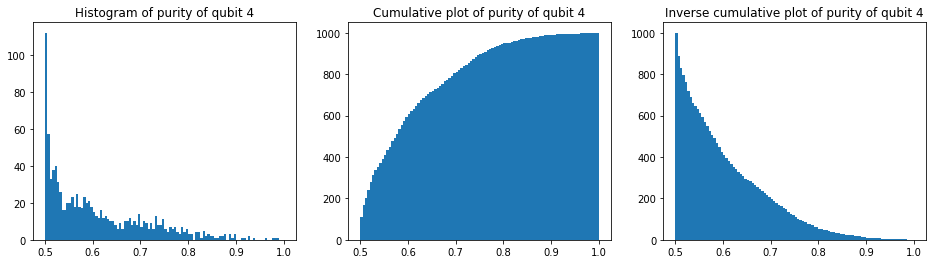

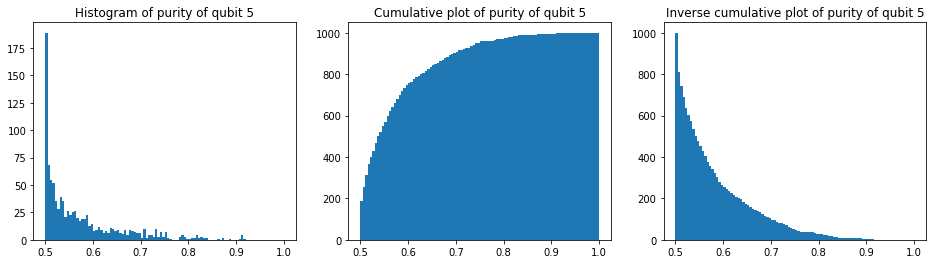

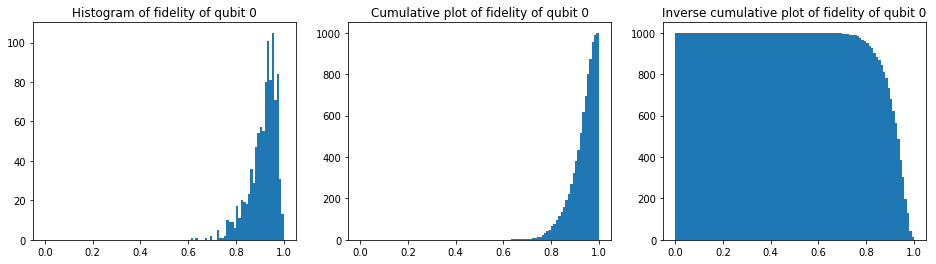

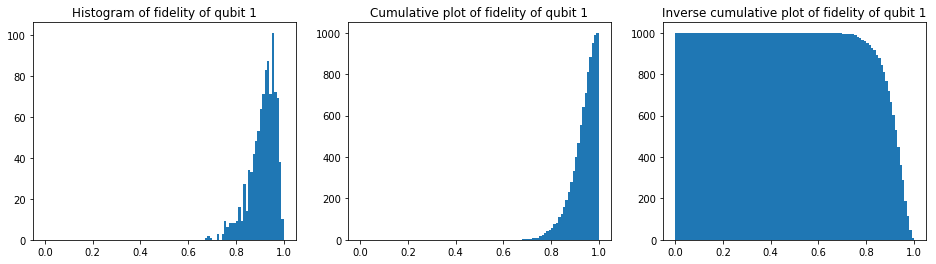

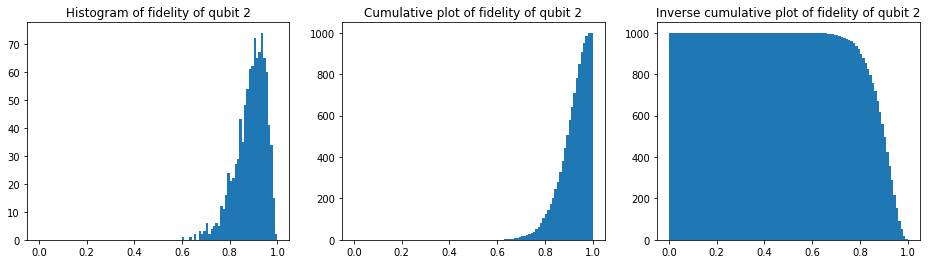

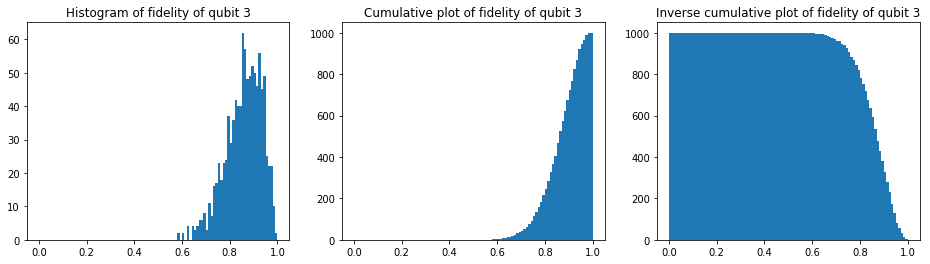

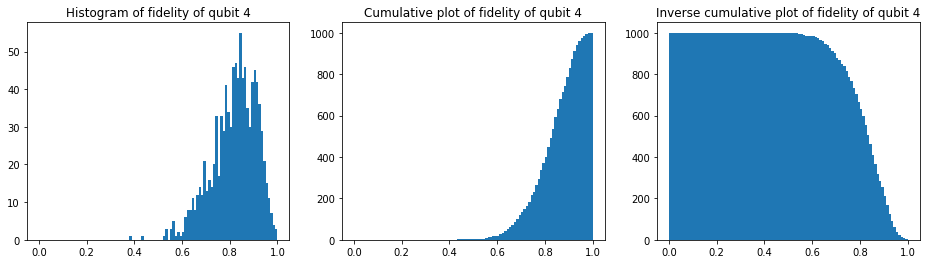

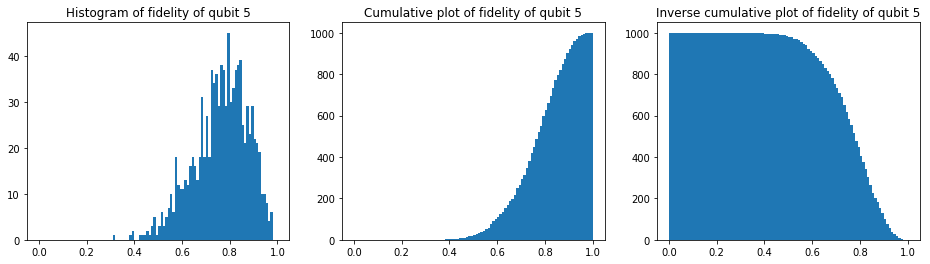





8


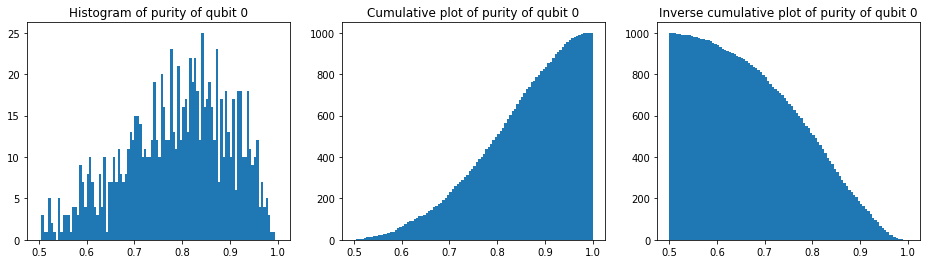

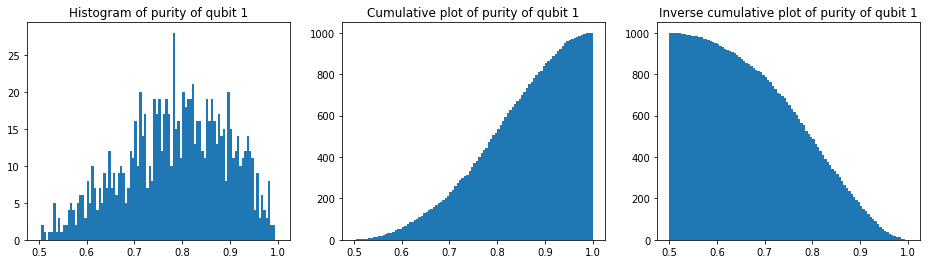

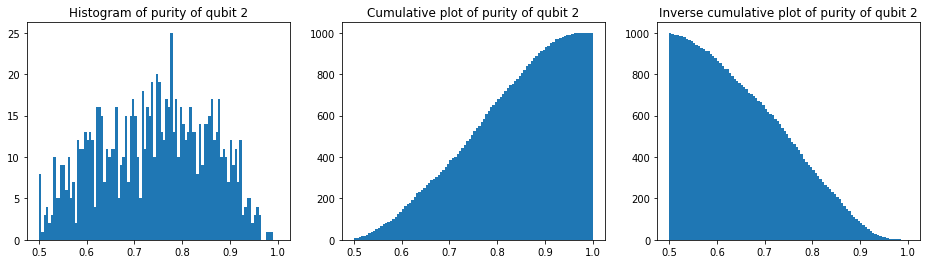

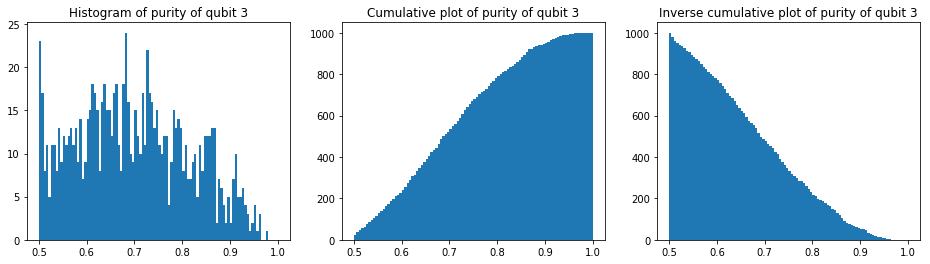

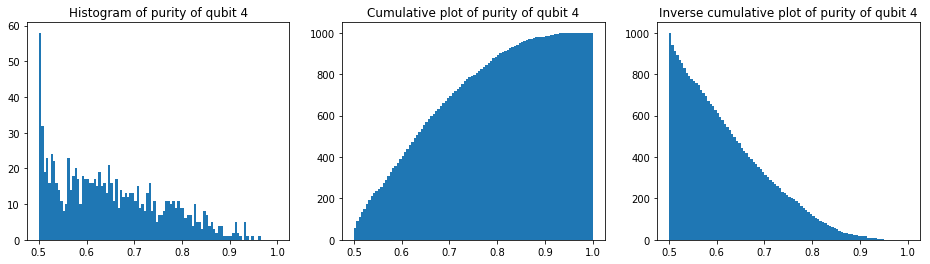

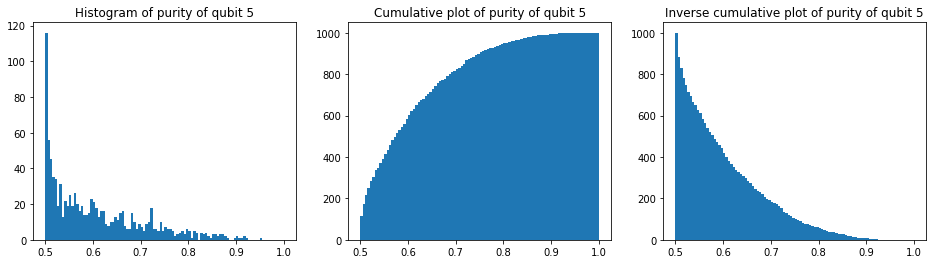

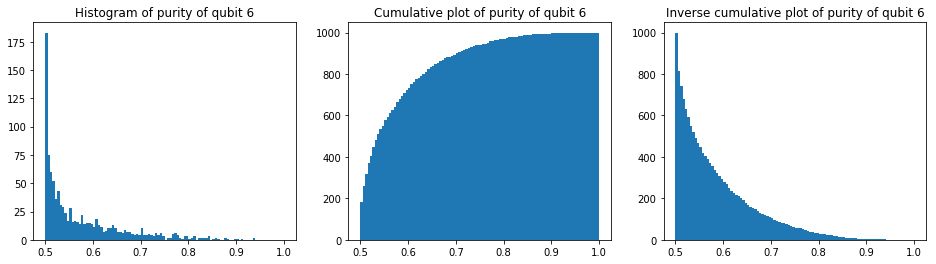

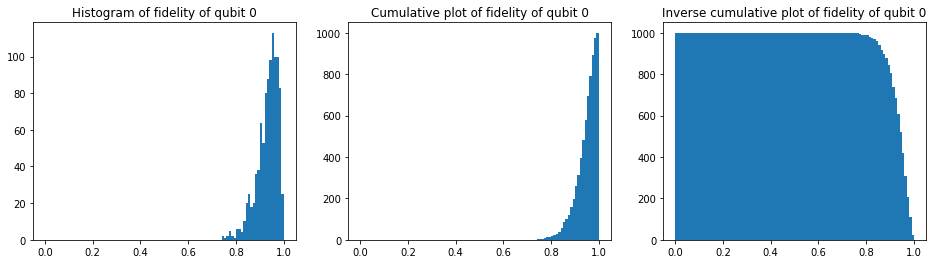

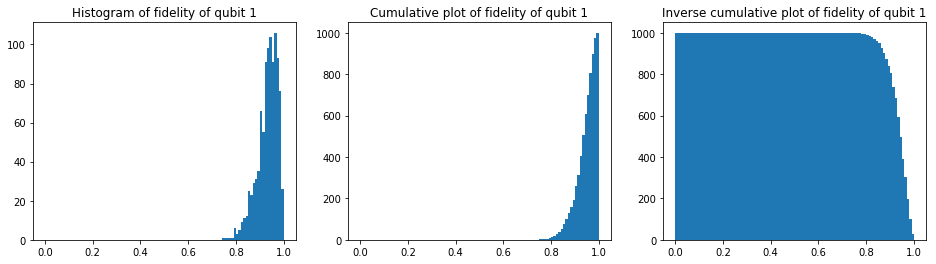

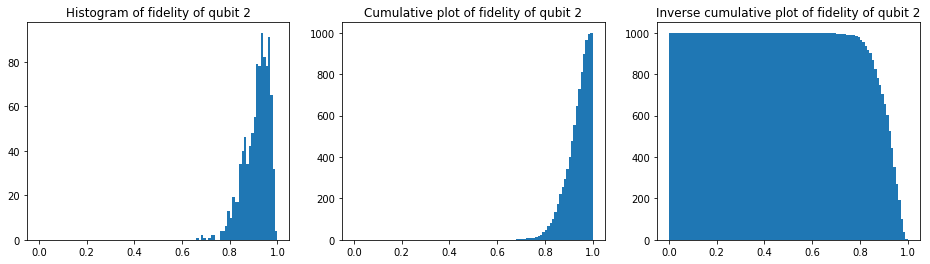

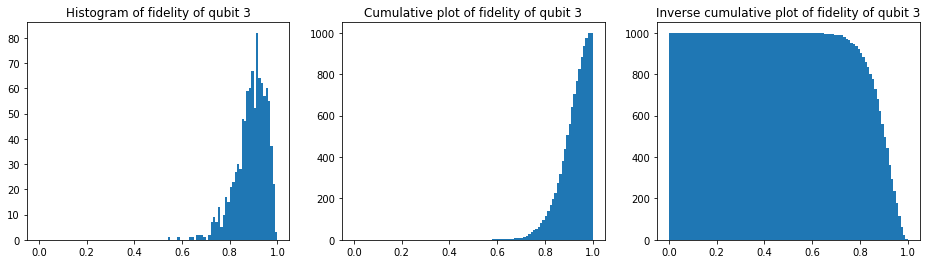

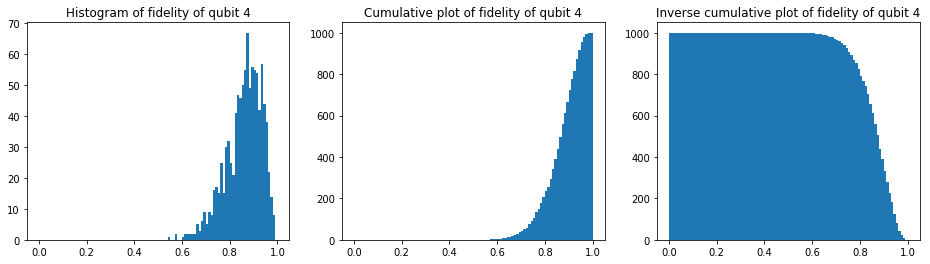

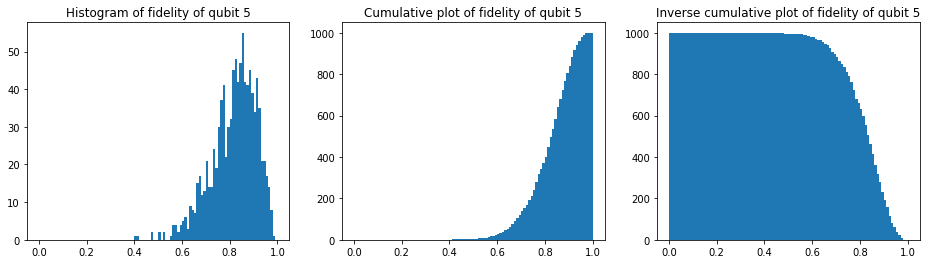

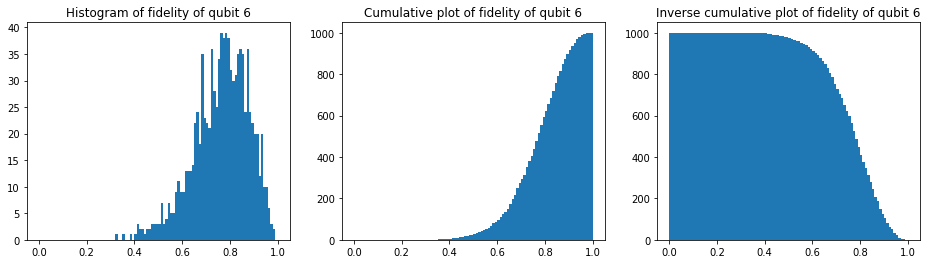





9


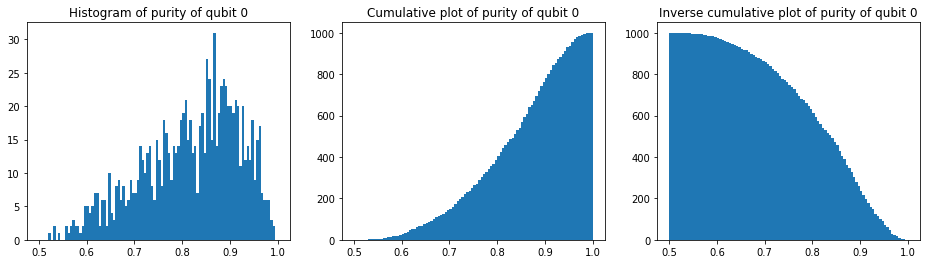

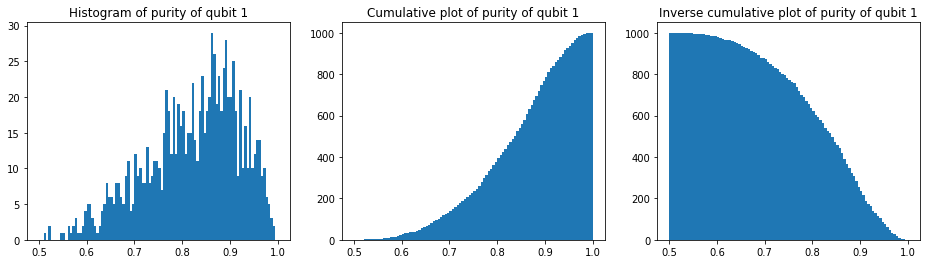

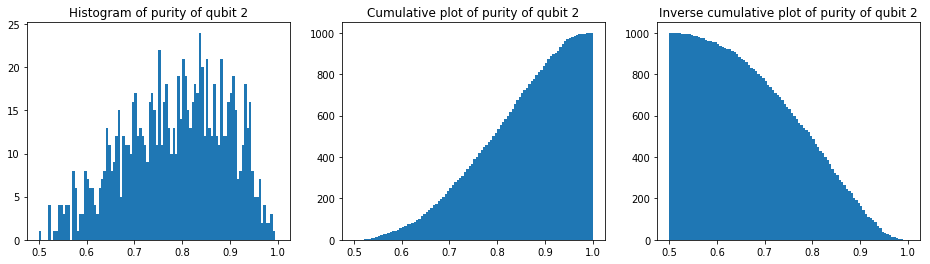

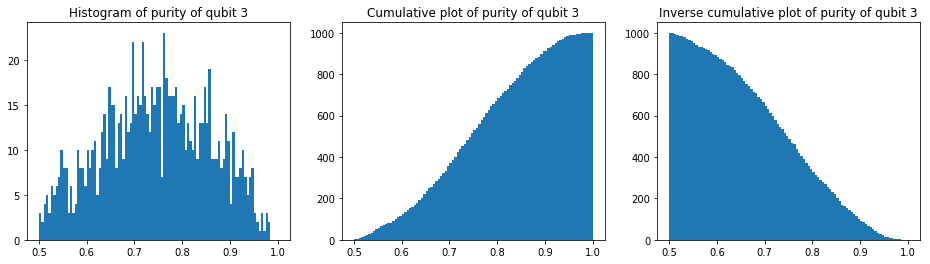

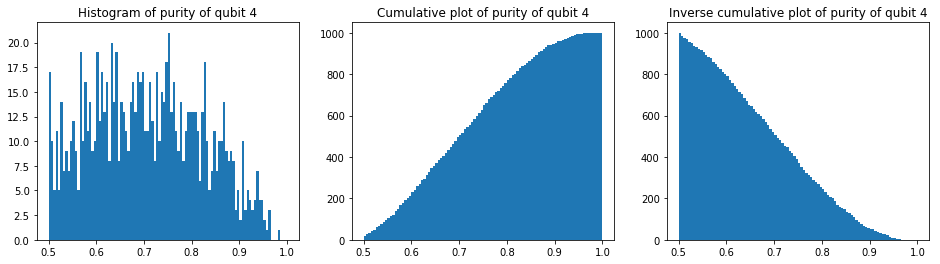

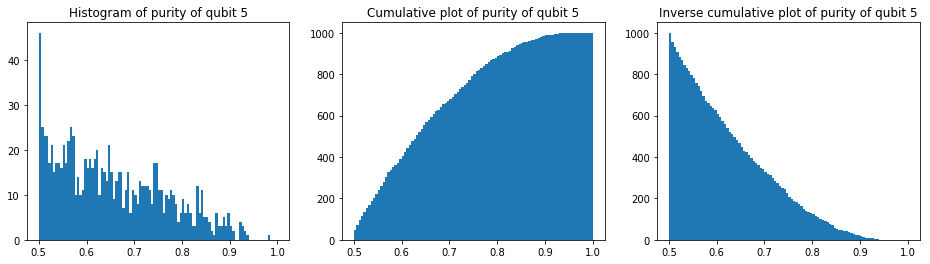

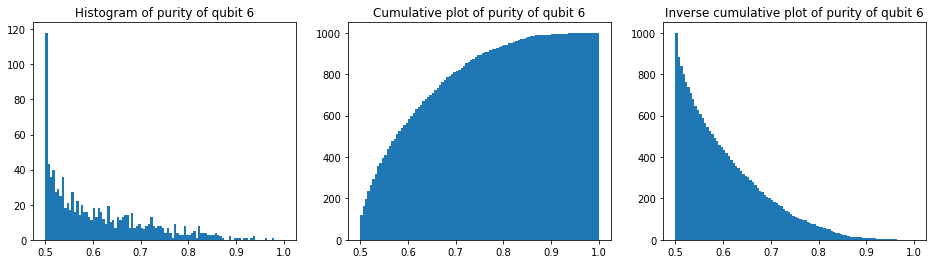

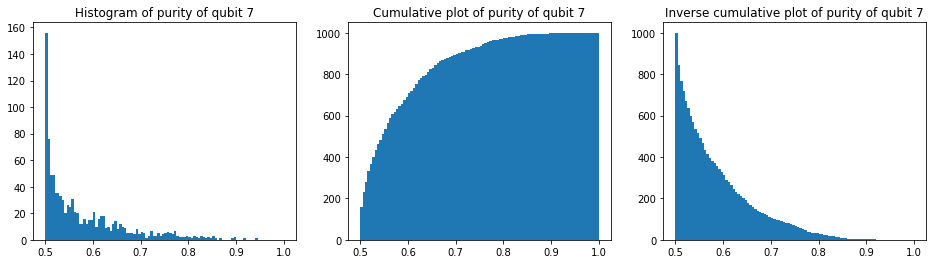

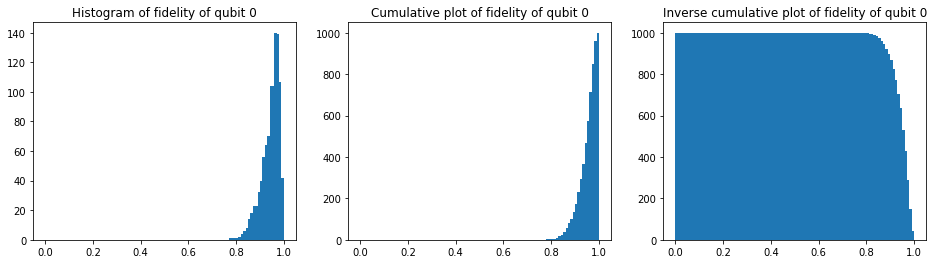

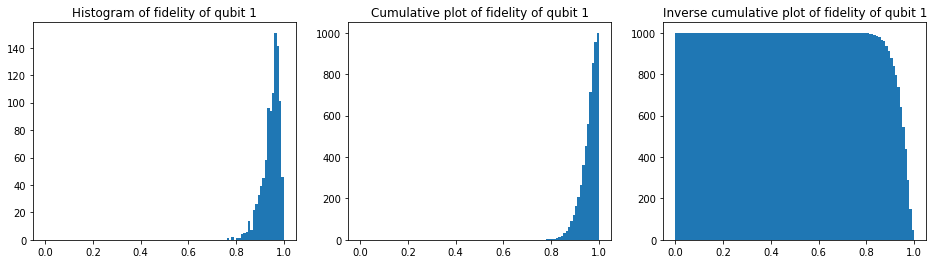

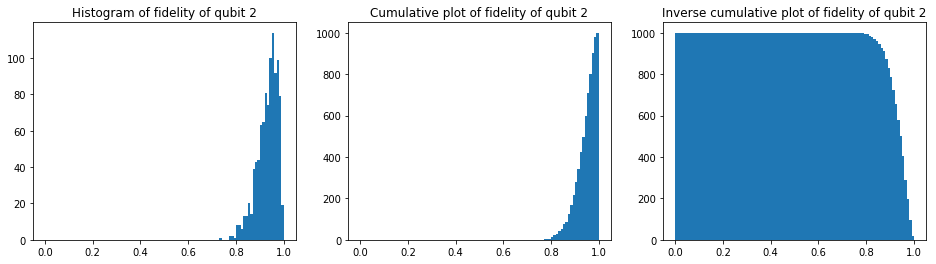

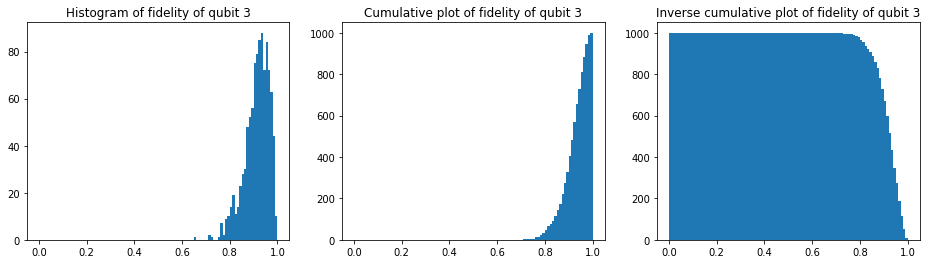

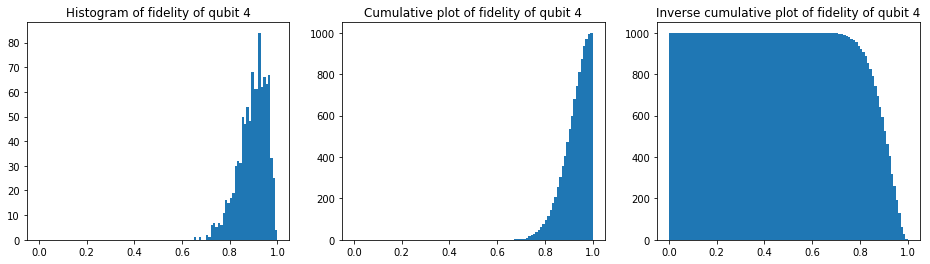

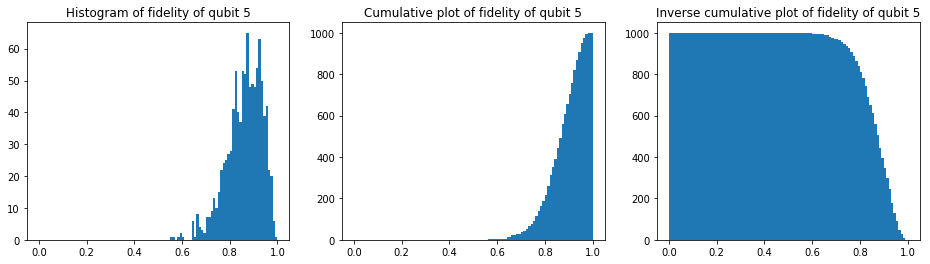

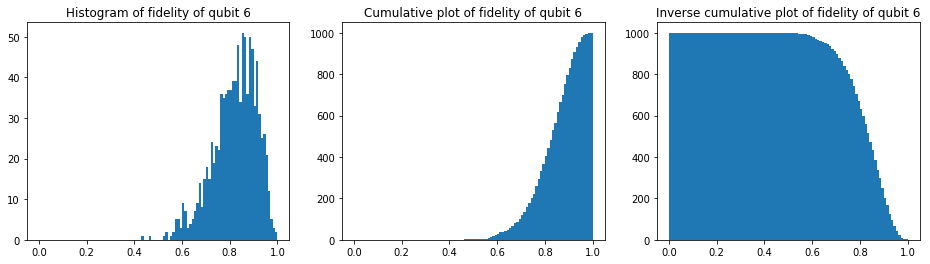

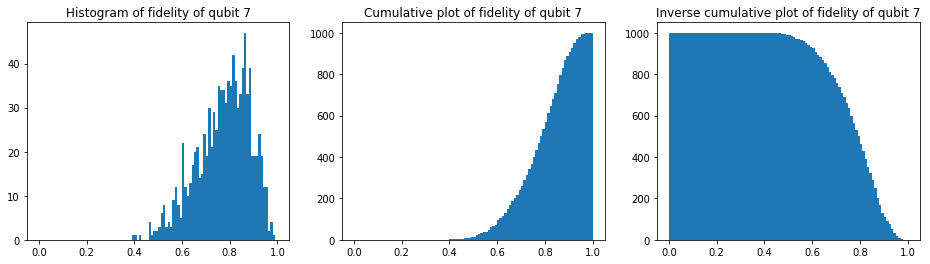





10


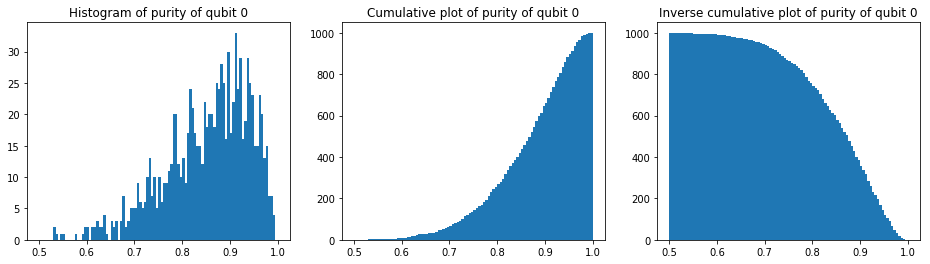

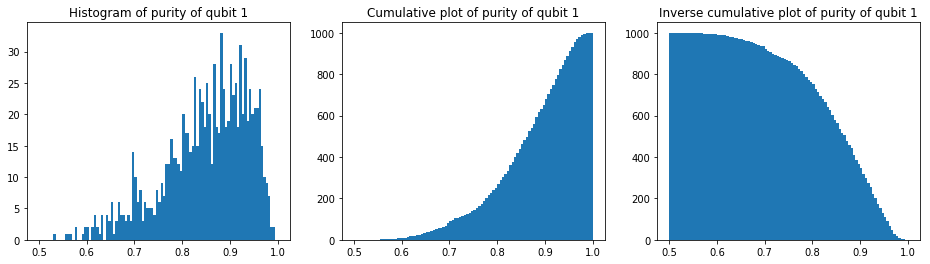

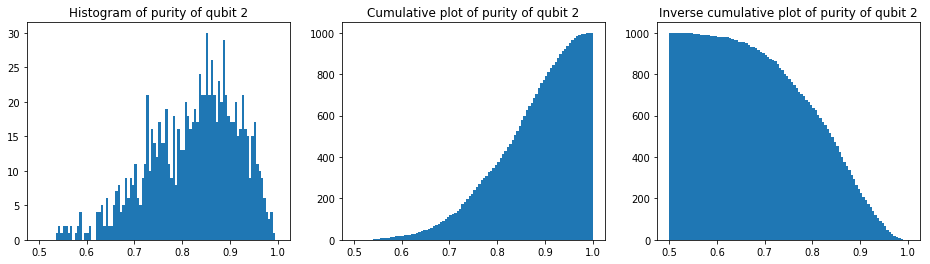

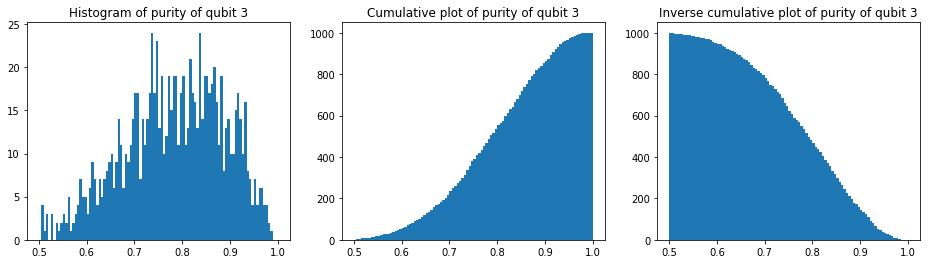

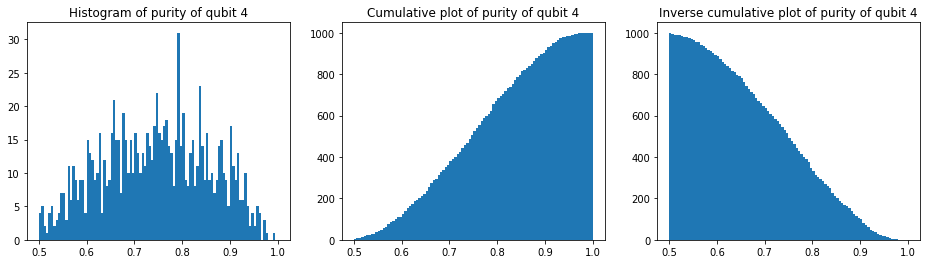

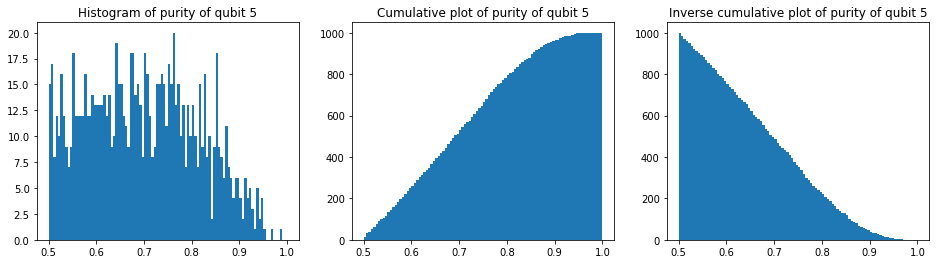

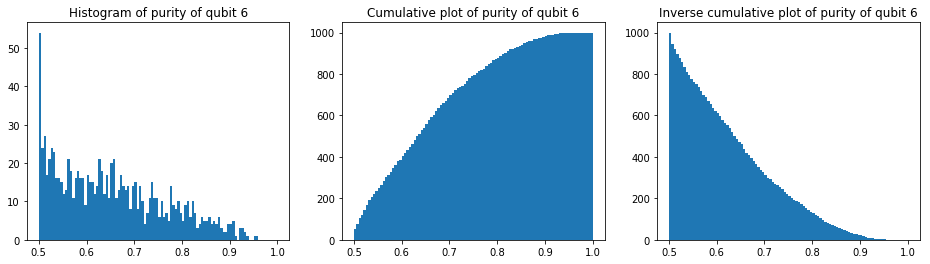

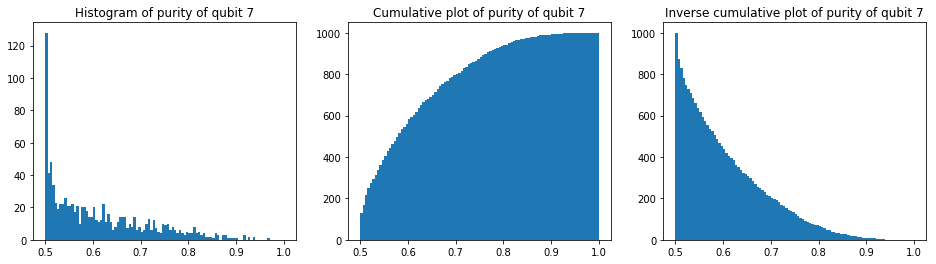

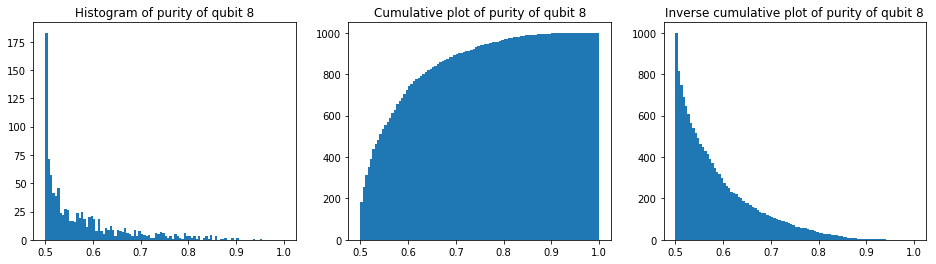

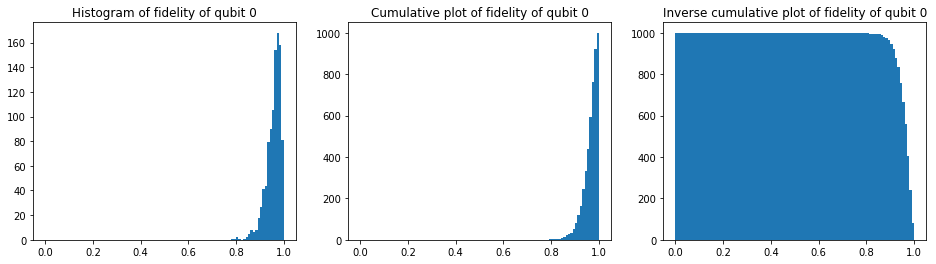

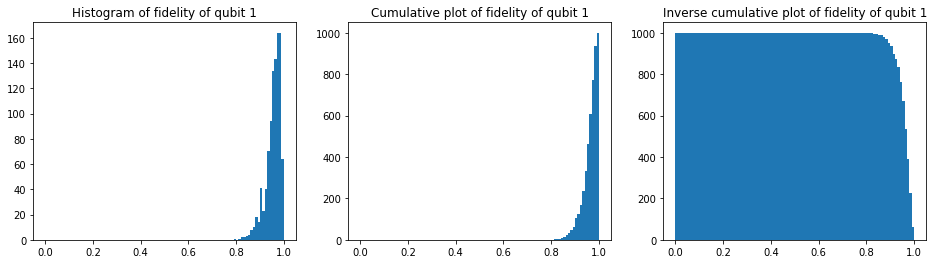

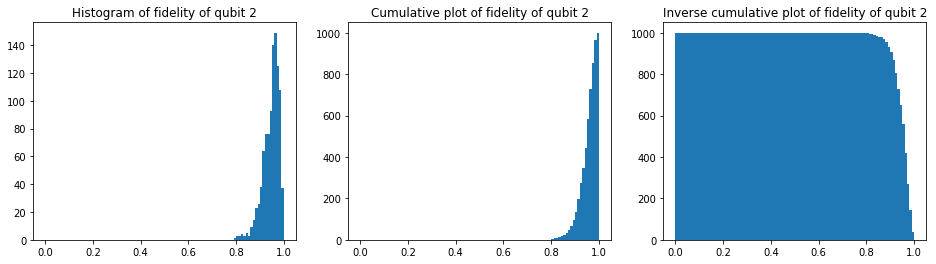

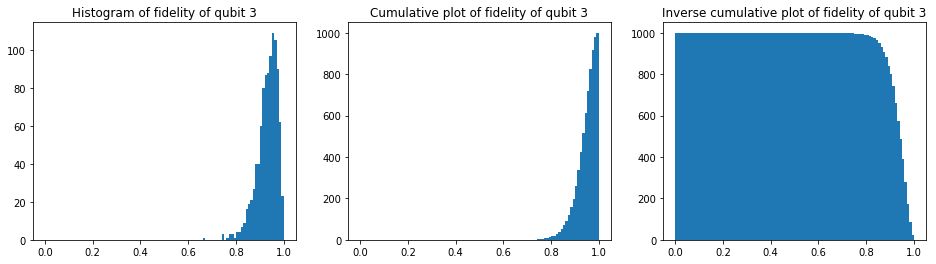

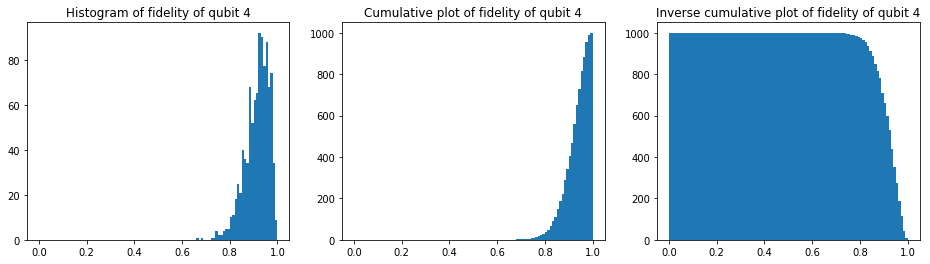

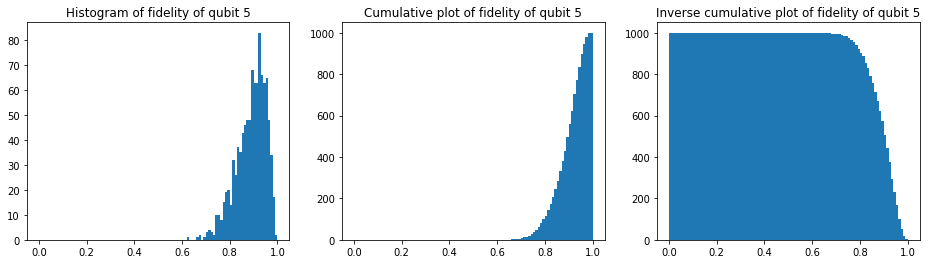

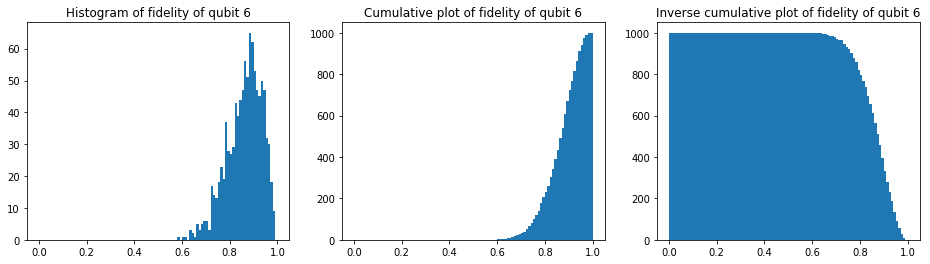

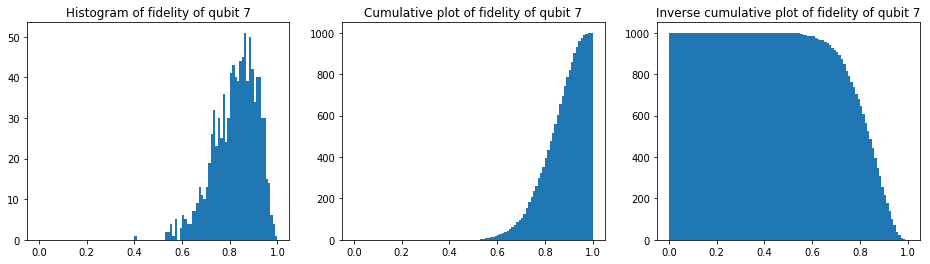

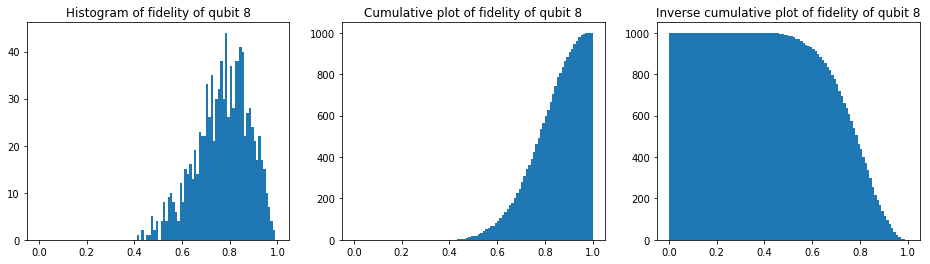

In [807]:
# Running ten circuits of 5 qubits, with gates and initial state chosen randomly

for test_n_qubits in [2, 3, 4, 5, 6, 7, 8, 9, 10]:
    print('\n\n\n')
    n_qubits = test_n_qubits
    print(n_qubits)

    purities = []
    fidelities = []
    
    for i in range(n_qubits - 1):
        purities.append([])
        fidelities.append([])

    for i in range(tot_tries):
        c = cirq.Circuit.from_ops(ladder_shifting([RandomUnitaryGate() for i in range(n_qubits - 1)]))
        random_run = simulator.simulate(c + cirq.inverse(c[:-1]))
        
        for i in range(n_qubits - 1):
            rho0 = cirq.partial_trace(random_run.final_simulator_state.density_matrix, [i]) 
            
            purity0 = np.trace(rho0*rho0)
            purities[i].append(purity0)
            
            fidelities[i].append(fidelity_against_0(rho0))
        
    for i in range(n_qubits - 1):
        purities[i] = np.array(list(map(abs, purities[i])))
        fidelities[i] = np.array(fidelities[i])

    # plot purities 
        
    for i in range(n_qubits - 1):
        
        fig = plt.figure(figsize=[16,4])
        
        ax = fig.add_subplot(1,3,1)

        ax.hist(purities[i], range=(0.5,1), bins=100) 
        ax.set_title('Histogram of purity of qubit ' + str(i))
        
        ax = fig.add_subplot(1,3,2)
        ax.hist(purities[i], range=(0.5,1), bins=100, cumulative=1)
        ax.set_title('Cumulative plot of purity of qubit ' + str(i))
        
        ax = fig.add_subplot(1,3,3)
        ax.hist(purities[i], range=(0.5,1), bins=100, cumulative=-11)
        ax.set_title('Inverse cumulative plot of purity of qubit ' + str(i))
        
        image_name = 'purity_circuit_size_{n_qubits}_qubit_number_{qubit_number}.png'.format(n_qubits = n_qubits, qubit_number = i)
        
        plt.savefig(isaac_images.joinpath(image_name))
        
        plt.show()
        
    make_gif(n_qubits, metric = 'purity') 
    # plot fidelities 
        
    for i in range(n_qubits - 1):
        
        fig = plt.figure(figsize=[16,4])
        
        ax = fig.add_subplot(1,3,1)

        ax.hist(fidelities[i], range=(0,1), bins=100) 
        ax.set_title('Histogram of fidelity of qubit ' + str(i))
        
        ax = fig.add_subplot(1,3,2)
        ax.hist(fidelities[i], range=(0,1), bins=100, cumulative=1)
        ax.set_title('Cumulative plot of fidelity of qubit ' + str(i))
    
        ax = fig.add_subplot(1,3,3)
        ax.hist(fidelities[i], range=(0,1), bins=100, cumulative=-11)
        ax.set_title('Inverse cumulative plot of fidelity of qubit ' + str(i))
        
        image_name = 'fidelity_circuit_size_{n_qubits}_qubit_number_{qubit_number}.png'.format(n_qubits = n_qubits, qubit_number = i)
        
        plt.savefig(isaac_images.joinpath(image_name))
        
        plt.show()
        
    make_gif(n_qubits, metric = 'fidelity')

